# Generative Modelling for  Spatial Inference : An amortized SBI approach with transformer-enhanced diffusion model.

In [ ]:
#@title requirements (might take some time)
try:
  from utils import install_packages
except:
  # Colab
  !git clone https://github.com/hermanFTT/SpatFormer.git
  from SpatFormer.building_block.utils import install_packages
  #from google.colab import output         # activate if running the code on colab 
  #output.enable_custom_widget_manager()

install_packages()  # install required packages

In [ ]:
# sbi module
!pip install sbi
#!pip install --upgrade numpy xarray arviz packaging

In [2]:
#check the version of NVIDIA's CUDA compiler (nvcc)
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Wed_Nov_22_10:17:15_PST_2023
Cuda compilation tools, release 12.3, V12.3.107
Build cuda_12.3.r12.3/compiler.33567101_0


In [5]:
#@title Importing essential modules
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import pickle
import random
from matplotlib.ticker import LogLocator


# general
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
import seaborn as sns
from sklearn.neighbors import KernelDensity

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.distributions as dist
from torch.distributions import Distribution
from tqdm import tqdm

# sklearn
from logging import warning
from typing import Any, Dict, Optional, Union
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from torch import Tensor

# Numpyro                                # Numpyro is not compatible with the Jax version used for this project
# import numpyro
# import numpyro.distributions as npdist
# import random as rnd
# from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
# from numpyro.diagnostics import hpdi
#numpyro.set_host_device_count(4)

#JAX version 0.4.31
import jax
from jax import random
import jax.numpy as jnp


# #SBI
from sbi.inference import  prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

# check versions
#print(numpyro.__version__)
print(jax.__version__)
print(torch.__version__)
from platform import python_version
print(python_version())

# code agnostic device
device="cuda" if torch.cuda.is_available() else "cpu"

0.4.26
2.4.0
3.10.14


In [2]:
# Jax version 0.4.23
import jax
import jax.numpy as jnp
import jax.random as jrandom
from jax.random import PRNGKey
from jax import Array
import os


import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
from functools import partial
from typing import Tuple, List, Optional

# Load some small helper functions 
from functools import partial
from probjax.utils.sdeint import sdeint
from probjax.distributions.sde import VESDE
import haiku as hk # Neural network library
import optax # Gradient-based optimization in JAX
from probjax.nn.transformers import Transformer
from probjax.nn.helpers import GaussianFourierEmbedding
from probjax.nn.loss_fn import denoising_score_matching_loss
from probjax.distributions import Empirical, Independent
from scoresbibm.utils.plot import use_style
from sbi.analysis import pairplot
import numpy as np
jax.devices() # Should be cuda
_ = os.system("nvidia-smi  --query-gpu=name --format=csv,noheader") # Should show GPU info


Tesla T4
Tesla T4


In [30]:
#@title Configurations 
# all configurations are tracked here
args = {
        
    "key": 3,      # jax key for reproductibility

    # Diffusion Process configurations ( Variance Exploding SDE )
            "T" : 1.,      # final time step
        "T_min": 1e-2,      # initial time step 
        "sigma_min" : 1e-3, # min scale 
        "sigma_max" : 15. , # max scale
    
    # 1D GP experiment setup
        "n_data_points":80, #80     # number of grid points ( dimensionality)
        "n_samples":5000,  # number posteriors samples
        "x_lim_low": 0,    # limits of the 1D grid
        "x_lim_high": 1,   
        "num_sim":[1000,3000,6000,10000], # ,25000    # number of simulations 
        "noise": 0.1,            # noise scale
    
    # observed data location ( can add any mask of interest in the list, if None, random mask will be apply during training )
        "obs_locations": [np.array([11,23, 39,50,61,72]),np.array([ 2, 11, 19, 27, 35, 43, 51, 59, 67, 75])],  #[np.array([10,23, 40, 61,75]),np.array([4,6, 40, 65,67]),np.array([10,12, 61,75]),
                          #np.array([11,23, 39,50,61,72]),np.array([6,8,11, 38,40, 68,70,72]),np.array([8,11, 38,40, 68,70]),
                          #np.array([ 2, 11, 19, 27, 35, 43, 51, 59, 67, 75]),np.array([ 2, 12, 22, 32, 42, 52, 62, 72])],       # add desired set of locations (masks)'

    # Latent dimensions (play around with the embedding dimension for the tokenizer components)
        "dim_value": 20 ,     # Size of the value embedding
        "dim_id": 20, #1      # Size of the node id embedding
        "dim_condition": 10,  # Size of the condition embedding
        "time_emb": 64,       # size of the time embedding 
        #"coord_emb": 5        # coordinate embeddings 
       
    # Training setting
        "epoch": 20,
        "inner_loop": 3000,
        "lr": 1e-3 , # learning rate

    # 2D GP experiment
        "bound":[-5,5],          # bound of the square grid
        "dimensionality": 10,    #n=20*20 grid points
        "n_obs_pts":[16,40,64],  # add desired  number of  observed data points at multiple scarce locations
       
       }

In [ ]:

x = np.linspace(args["x_lim_low"],  args["x_lim_high"] , args["n_data_points"])
x = torch.tensor(x).type(torch.float32)
N=len(x)

# Kernel functions 

In [6]:
#@title   Radial basis function kernel  (RBF)
x = np.linspace(args["x_lim_low"],  args["x_lim_high"] , args["n_data_points"])
x = torch.tensor(x).type(torch.float32)

def dist_euclid(x, z):
    x = torch.as_tensor(x)
    z = torch.as_tensor(z)
    if len(x.shape) == 1:
        x = x.unsqueeze(1)
    if len(z.shape) == 1:
        z = z.unsqueeze(1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = torch.zeros((n_x, n_z))
    for d in range(m):
        x_d = x[:, d]
        z_d = z[:, d]
        delta += (x_d[:, None] - z_d) ** 2
    return torch.sqrt(delta)

def gp_kernel(ls ,x=x, z=x,sigma=1, noise=0, jitter=1.0e-5):
    dist = dist_euclid(x, z)
    deltaXsq = torch.pow(dist / ls, 2.0)
    k = (sigma ** 2) * torch.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * torch.eye(x.shape[0], device=x.device)
    return k


##The Matérn kernel

The Matérn kernel (or Matérn covariance function) is a popular kernel used in Gaussian Process (GP) models, particularly for modeling spatial data. It controls the smoothness of the functions generated by the GP. The Matérn kernel is more flexible than the commonly used squared exponential (RBF) kernel because it has an additional parameter that controls the smoothness of the function.

$$
k_{\text{Matérn}}(x, x') = \sigma^2 \frac{2^{1-\nu}}{\Gamma(\nu)} \left( \frac{\sqrt{2\nu} d}{\ell} \right)^\nu K_\nu \left( \frac{\sqrt{2\nu} d}{\ell} \right)
$$

where:
- $ d = \|x - x'\| $ is the Euclidean distance between the two points,
- $\ell $ is the length scale,
- $ \nu $ is the smoothness parameter,
- $ \sigma^2 $ is the variance,
- $ K_\nu $ is the modified Bessel function of the second kind,
- $ \Gamma(\nu) $ is the gamma function.






In [7]:
# #@title  Matérn kernel function
def matern_kernel(ls=1,X=x.unsqueeze(-1), X_prime=x.unsqueeze(-1), nu=2.5, variance=1.0, jitter=1.0e-6):
    """
    Compute the Matérn kernel between two sets of input points.

    Parameters:
    X : torch.Tensor
        A tensor of shape (N, D), where N is the number of points and D is the dimensionality.
    X_prime : torch.Tensor
        A tensor of shape (M, D), where M is the number of points and D is the dimensionality.
    nu : float
        The smoothness parameter of the Matérn kernel. Common values are 0.5, 1.5, and 2.5.
    ls : float
        The length scale parameter, controlling the distance over which correlations decay.
    variance : float
        The variance (amplitude) parameter, controlling the vertical scaling.

    Returns:
    torch.Tensor
        The computed Matérn kernel matrix of shape (N, M).
    """
    # Compute pairwise Euclidean distances between X and X_prime
    distance = torch.cdist(X, X_prime, p=2)  # (N, M)

    # Compute the Matérn kernel based on the value of nu
    if nu == 0.5:
        # Special case: Exponential kernel (Matern with nu=0.5)
        K = torch.exp(-distance / ls)
    elif nu == 1.5:
        sqrt_3 = math.sqrt(3)
        term = sqrt_3 * distance / ls
        K = (1.0 + term) * torch.exp(-term)
    elif nu == 2.5:
        sqrt_5 = math.sqrt(5)
        term = sqrt_5 * distance / ls
        K = (1.0 + term + (term ** 2) / 3.0) * torch.exp(-term)
    else:
        raise NotImplementedError("Matérn kernel with arbitrary nu is not implemented.")
    K= K + jitter * torch.eye(K.shape[0])    # ensure numerical stability
    # Scale by variance
    return variance * K


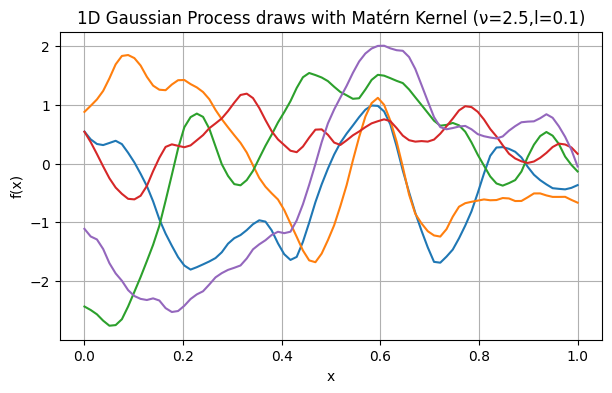

In [9]:
#@title Exemple samples in 1D
# Step 1: Generate 1D points
#N = 80  # Number of points

# Compute the covariance matrix using the Matérn kernel
nu = 2.5  # Smoothness parameter
length_scale = 0.1  # Length scale
variance = 1.0  # Variance

cov_matrix = matern_kernel(ls=0.1,variance = 1.0)

#  Generate GP samples (mean zero, covariance from Matérn kernel)
mean = torch.zeros(N)  # Zero mean
gp = MultivariateNormal(mean, covariance_matrix=cov_matrix)

# Sample from the GP
samples = gp.sample((5,))  # Generate 3 samples

# Plot the GP samples
plt.figure(figsize=(7, 4))
for i in range(5):
    plt.plot(x.numpy(), samples[i].numpy(), label=f'Sample {i+1}')

plt.title('1D Gaussian Process draws with Matérn Kernel (ν=2.5,l=0.1)')
plt.xlabel('x')
plt.ylabel('f(x)')
#plt.legend()
plt.grid(True)
plt.show()


\begin{align}
\theta&\sim p(\theta)\\
f\mid \theta&\sim
GP(\mu,\Sigma(\theta) )\\
\eta&=X\beta +f\\
y\mid \eta &\sim p(u^{-1}(\eta),\theta)
\end{align}

#   Inference  model



In [70]:
#@title Likelihood (simulator ) and GP priors .

class CustomPrior(Distribution):
    def __init__(self, low, high,cov_func):
        super().__init__()
        self.dist1 = dist.Uniform(low=low, high=high) # prior over lenghtscale
        #self.dist2 = dist.HalfNormal(scale)
        self.cov_func = cov_func  # Function to compute covariance matrix

    def sample(self, sample_shape=torch.Size()):
        sample1 = self.dist1.sample(sample_shape) # ls
        #sample2 = self.dist2.sample(sample_shape) # epsilon
        # Calculate covariance matrix using the sample from dist1
        if sample1.dim()==0:
          K= self.cov_func(ls=sample1)
          dist3 = dist.MultivariateNormal(loc=torch.zeros(K.shape[0]), covariance_matrix=K)
          sample3=dist3.sample()
          samples=sample3
        else:
          sample_list=[]
          for ls in sample1:
            K= self.cov_func(ls=ls)   #GP_kernel
            # Create dist3 using the calculated covariance matrix
            dist3 = dist.MultivariateNormal(loc=torch.zeros(K.shape[0]), covariance_matrix=K)
          # Sample from dist3
            sample_list.append(dist3.sample())
          # combine sample
          sample3= torch.stack(sample_list)

            # Concatenate sample1, sample2, and sample3 along the last dimension
          samples = sample3
        return samples

    def log_prob(self):
        pass

### define the prior and the Model simulator model

## GP priors with RBF kernel
prior=CustomPrior(low=0.1, high=0.4, cov_func=gp_kernel)                 
      

## GP priors with Matern kernel
K = matern_kernel(ls=length_scale)
mean = torch.zeros(N)  # Zero mean
prior2= MultivariateNormal(mean, covariance_matrix=cov_matrix) 

## Likelihood
def likelihood(theta):
  epsilon=dist.HalfNormal(args["noise"]).sample() #0.1
  if theta.dim()==1:
    f_gp=theta                             #[np.array(obs_idx)]
  else:
    f_gp=(theta[:,:]).squeeze()             #np.array(obs_idx)

  mean,cov=f_gp,(epsilon**2)*torch.eye(len(f_gp))
  y=dist.MultivariateNormal(mean,cov).sample()
  # y= f_gp + epsilon*torch.randn_like(f_gp)
  return y.unsqueeze(0)


In [18]:
#@title Indices ( location unit ) of observed data
obs_idx_lst=args["obs_locations"]

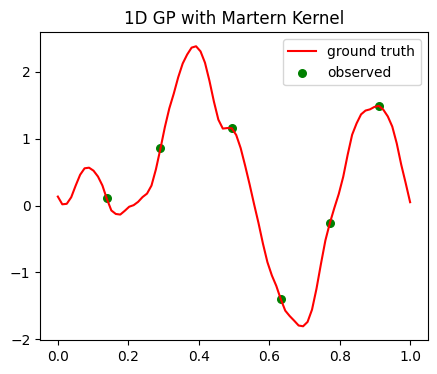

In [19]:
#@title GP  Priors with Martern kernel
torch.manual_seed(60)
p=prior2.sample()    # Matern Kernel based GP prior
y_true=p
def play_simul(prior,simulator,obs_idx_lst=obs_idx_lst,idx=0,title="1D GP with Martern Kernel"):
  plt.figure(figsize=(5,4))
  if idx<len(obs_idx_lst):
      x_obs = x[np.array(obs_idx_lst[idx])]
      y_obs=simulator(prior).squeeze().numpy()
      plt.plot(x.numpy(),prior.numpy(),label="ground truth", color="red")
      plt.scatter(x_obs,y_obs[obs_idx_lst[idx]], color="green", label="observed", s=30)
      plt.title(title)
      plt.legend()
      plt.show()
      y_observations=[]
      for i in range(len(obs_idx_lst)):
            y_observations.append(y_obs[obs_idx_lst[i]])
      return y_observations
y_observations = play_simul(p,likelihood,idx=0)

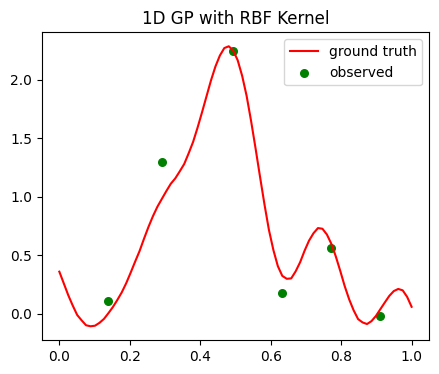

In [71]:
#@title GP  Priors with RBF kernel
torch.manual_seed(3)          #4 ,16, 22,23,29,38,40 (best),45(best),47( more fluc),54,68,72
p=prior.sample()                # RBF-based GP prior
y_true=p
y_observations = play_simul(p,likelihood,idx=0,title="1D GP with RBF Kernel")      

In [20]:
#@title Set random key
key = jax.random.PRNGKey(args["key"])
print(jax.devices())  # available device

[cuda(id=0), cuda(id=1)]


In [21]:
#@title Simulate synthetic data for training ( 10000 simulated samples).
theta,_ = simulate_for_sbi(likelihood, proposal=prior2, num_simulations=args["num_sim"][-1]) 

#reshape to match for tokenizer input requirements
data=jnp.array((np.array(theta.unsqueeze(-1))))
#data=jnp.array((np.array(torch.cat((theta, y), dim=1).unsqueeze(-1))))
nodes_max = data.shape[1]                       # each variable is consider a node of a graph
node_ids = jnp.arange(nodes_max)                # node Id ( position )
print(f'data shape:{data.shape}')               # (Batch_dim, node_max ,1)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

data shape:(10000, 80, 1)


# Transformer-based diffusion model architecture

In [24]:
#@title  Setting up the diffusion process (VESDE)

T = args["T"]
T_min = args["T_min"]
sigma_min = args["sigma_min"]
sigma_max = args["sigma_max"]

p0 = Independent(Empirical(data), 1) # Empirical distribution of the data
sde = VESDE(p0, sigma_min=sigma_min , sigma_max=sigma_max)

# Scaling fn for the output of the score model
def output_scale_fn(t, x):
    scale = jnp.clip(sde.marginal_stddev(t, jnp.ones_like(x)), 1e-2, None)
    return (1/scale * x).reshape(x.shape)

###  Building the architecture:

Two main components:

* **Tokenizer**:
This component jointly embeds 'x', 'node_ids/coordinates', and the 'condition_mask' into a unified
vector known as a token.
    * **Value Embedding**: Embeds the value of the variable.
    * **Node/coord Embedding**: Embeds the coordinate or node ID.
    * **Condition Embedding**: Embeds the condition mask.
* **Transformer**: This is a transformer model that takes tokens as input and generates scores for each node.
    * **Num_heads**: Specifies the number of heads in the multi-head attention mechanism.
    * **Attn_size**: Determines the size of attention, i.e., the dimensions to which query and key are projected.
    * **Num_layers**: Sets the number of layers in the transformer.
    * **Widening_factor**: Specifies the factor by which the hidden size of the MLP is increased in each layer.

 we construct a compact SpatFormer with 2 layers and 2 heads.


In [26]:
#@title build the Embedding modules + Transformer architecture

#setup the latent dimensions
dim_value = args["dim_value"]      # Size of the value embedding
dim_id =  args["dim_id"]         # Size of the coord embedding
dim_condition = args["dim_condition"]  # Size of the condition embedding
time_dim=args["time_emb"]


def model(t: Array, x: Array, node_ids: Array, condition_mask:Array, edge_mask: Optional[Array]=None):
    """Simplified Simformer model.

    Args:
        t (Array): Diffusion time
        x (Array): Value of the nodes
        node_ids (Array): Id of the nodes
        condition_mask (Array): Condition state of the nodes
        edge_mask (Array, optional): Edge mask. Defaults to None.
    Returns:
        Array: Score estimate of p(x_t)
    """

    batch_size, seq_len, _ = x.shape
    condition_mask = condition_mask.astype(jnp.bool_).reshape(-1,seq_len, 1)
    node_ids = node_ids.reshape(-1,seq_len)
    t = t.reshape(-1,1, 1)

    # Diffusion time embedding net (here we use a Gaussian Fourier embedding)
    embedding_time = GaussianFourierEmbedding(time_dim)  # Time embedding method
    time_embeddings = embedding_time(t)

    # Tokinization part --------------------------------------------------------------------------------

    embedding_net_value = lambda x: jnp.repeat(x, dim_value, axis=-1)    # Value embedding net ( we just repeat the value)
    embedding_net_id = hk.Embed(nodes_max, dim_id, w_init=hk.initializers.RandomNormal(stddev=3.))   # coord/id embedding nets (we use a learnable random embedding vector)
    condition_embedding = hk.get_parameter("condition_embedding", shape=(1,1,dim_condition), init=hk.initializers.RandomNormal(stddev=0.5)) #Condition embedding (here we use a learnable random embedding vector)
    condition_embedding = condition_embedding * condition_mask # If condition_mask is 0, then the embedding is 0, otherwise it is the condition_embedding vector
    condition_embedding = jnp.broadcast_to(condition_embedding, (batch_size, seq_len, dim_condition))

    # Embed inputs and broadcast
    value_embeddings = embedding_net_value(x)
    id_embeddings = embedding_net_id(node_ids)
    value_embeddings, id_embeddings = jnp.broadcast_arrays(value_embeddings, id_embeddings)

    # Concatenate embeddings (alternatively we can also add instead of concatenating)
    x_encoded = jnp.concatenate([value_embeddings,id_embeddings, condition_embedding], axis=-1) 

    # Transformer part --------------------------------------------------------------------------------
    model = Transformer(num_heads=2, num_layers=2, attn_size=10, widening_factor=3)

    # Encode -  use a transformer to transform the tokenized inputs into a latent representation
    h = model(x_encoded, context=time_embeddings, mask=edge_mask)

    # Decode - here we just use a linear layer to get the score estimate (we scale the output by the marginal std dev)
    out = hk.Linear(1)(h)
    out = output_scale_fn(t, out) # SDE dependent output scaling
    return out

In [114]:
# load model params
# with open("/kaggle/working/tree_params_GP_all_in_one_Martern_kernel.pkl", 'rb') as file: #tree_params_GP_all_in_one_Martern_kernel.pkl
#            params= pickle.load(file)


In [27]:
#@title  Initialize the model .( as require in Haiku )
# Init function initializes the parameters of the model, model_fn is the actual model function (which takes the parameters as first argument)

init, model_fn= hk.without_apply_rng(hk.transform(model))
params=init(key, jnp.ones(data.shape[0]), data, node_ids, jnp.zeros_like(node_ids))

# view total number of parameters and their shapes
print("Total number of parameters: ", jax.tree_util.tree_reduce(lambda x,y: x+y, jax.tree_map(lambda x: x.size, params)))
jax.tree_util.tree_map(lambda x: x.shape, params) # Here we can see the shapes of the parameters

Total number of parameters:  47314


{'embed': {'embeddings': (80, 20)},
 'gaussian_fourier_embedding': {'B': (33, 1)},
 'linear': {'b': (1,), 'w': (50, 1)},
 'transformer/layer_norm': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_1': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_2': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_3': {'offset': (50,), 'scale': (50,)},
 'transformer/layer_norm_4': {'offset': (50,), 'scale': (50,)},
 'transformer/linear': {'b': (150,), 'w': (50, 150)},
 'transformer/linear_1': {'b': (50,), 'w': (150, 50)},
 'transformer/linear_2': {'b': (50,), 'w': (64, 50)},
 'transformer/linear_3': {'b': (150,), 'w': (50, 150)},
 'transformer/linear_4': {'b': (50,), 'w': (150, 50)},
 'transformer/linear_5': {'b': (50,), 'w': (64, 50)},
 'transformer/multi_head_attention/key': {'b': (20,), 'w': (50, 20)},
 'transformer/multi_head_attention/linear': {'b': (50,), 'w': (20, 50)},
 'transformer/multi_head_attention/query': {'b': (20,), 'w': (50, 20)},
 'transformer/mult

In [ ]:
#with open("/kaggle/working/exp4_params.pkl", 'rb') as file:
 #     params=pickle.load(file)
    

In [28]:
#@title  Specify all conditionals of interests ( condition masks )
# set the index (Id/location) of the point we want to conditioned on.

# build the masks 
def build_mask(obs_idx_lst=obs_idx_lst,N=len(x)):
  """
  N (int): sequence length
  obs_idx_lst (list): list of indices/locations of the observed data points
  """
  masks_list=[]
  masks_list=[]
  for i in range(len(obs_idx_lst)):
    masks_list.append(jnp.zeros((N),dtype=jnp.bool_).at[obs_idx_lst[i]].set(1))
  return jnp.array(masks_list)

masks_list=build_mask()

/opt/conda/lib/python3.10/site-packages/jax/_src/ops/scatter.py:96: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=bool with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


In [29]:
#@title  The loss function
def weight_fn(t:Array):
    # MLE weighting
    return jnp.clip(sde.diffusion(t, jnp.ones((1,1,1)))**2, 1e-4)

def marginalize(rng: PRNGKey, edge_mask: Array):
    # Simple function that marginializes out a single node from a adjacency matrix of a graph.
    idx = jax.random.choice(rng, jnp.arange(edge_mask.shape[0]), shape=(1,), replace=False)
    edge_mask = edge_mask.at[idx, :].set(False)
    edge_mask = edge_mask.at[:, idx].set(False)
    edge_mask = edge_mask.at[idx, idx].set(True)
    return edge_mask

def loss_fn(params: dict, key: PRNGKey,masks_list=masks_list,batch_size:int= 1024):

    rng_time, rng_sample, rng_data, rng_condition, rng_edge_mask1, rng_edge_mask2 = jax.random.split(key, 6)

    # Generate data and random times
    times = jax.random.uniform(rng_time, (batch_size, 1, 1), minval=T_min, maxval=1.0)
    batch_xs = generator(rng_data, batch_size) # n, T_max, 1

    # Node ids (can be subsampled but here we use all nodes)
    ids = node_ids

## Condition mask -> randomly condition on some data.
    # ( activate the next 3 lines if interest in learning all possibe conditionals )
    #condition_mask = jax.random.bernoulli(rng_condition, 0.10, shape=(batch_xs.shape[0], batch_xs.shape[1]))
    # condition_mask_all_one = jnp.all(condition_mask, axis=-1, keepdims=True)
    # condition_mask *= condition_mask_all_one # Avoid conditioning on all nodes -> nothing to train...
    #condition_mask = condition_mask[..., None]
    
##Alternatively  set the condition mask manually to specific conditional distributions. ( defined by masks build previously )
    
    index = jax.random.randint(rng_condition, (), 0, len(masks_list))
    cond= masks_list[index]
    condition_mask= jnp.tile(jnp.expand_dims(cond,axis=0), (batch_xs.shape[0], 1))  # Replicate along the first dimension

    #one can also structure the base mask!
    #edge_mask = jnp.ones((4*batch_size//5, batch_xs.shape[1],batch_xs.shape[1]), dtype=jnp.bool_) # Dense default mask

    # Optional: Include marginal consistency
    # marginal_mask = jax.vmap(marginalize, in_axes=(0,None))(jax.random.split(rng_edge_mask1, (batch_size//5,)), edge_mask[0])
    # edge_masks = jnp.concatenate([edge_mask, marginal_mask], axis=0)
    # edge_masks = jax.random.choice(rng_edge_mask2, edge_masks, shape=(batch_size,), axis=0) # Randomly choose between dense and marginal mask

    # Forward diffusion, do not perturb conditioned data
    # We will use the condition mask to prevent adding noise for nodes that are conditioned.
    loss = denoising_score_matching_loss(params, rng_sample, times, batch_xs, condition_mask, model_fn= model_fn, mean_fn=sde.marginal_mean, std_fn = sde.marginal_stddev, weight_fn=weight_fn,node_ids=ids, condition_mask=condition_mask) #, edge_mask=edge_masks
    return loss

In [31]:
#@title training : heavily benefit from GPU acceleration & parallel computation 
optimizer = optax.adam(args["lr"])        # optimizer
opt_state = optimizer.init(params)        # initial params state

@partial(jax.pmap, axis_name="num_devices")                                 # parallelize computations
def update(params, rng, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng)                  # compute loss and gradients

    loss = jax.lax.pmean(loss, axis_name="num_devices")                     # aggregate loss accross devices ( mean )
    grads = jax.lax.pmean(grads, axis_name="num_devices")                   # aggregate gradients accross devices ( mean )

    updates, opt_state = optimizer.update(grads, opt_state, params=params)  #
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state


In [32]:
#@title replicate the model params and optimizer state across available devices for data-parallel computation
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)
replicated_opt_state = jax.tree_map(lambda x: jnp.array([x] * n_devices), opt_state)

In [33]:
#@title define data generator:
def generator(key: PRNGKey, n:int):
    key1,key2= jrandom.split(key,2)
    theta,_ = simulate_for_sbi(likelihood, proposal=prior2, num_simulations=n)
    return jnp.array((np.array( theta.unsqueeze(-1))))              #jnp.array((np.array(torch.cat((theta, y), dim=1).unsqueeze(-1)))) 

In [116]:
#training loop
start_time=time.time()
key = jrandom.PRNGKey(2)
train_loss=[]
epochs=args["epoch"]
for epoch in range(epochs):
    l = 0
    for i in range(args["inner_loop"]):
        key, subkey = jrandom.split(key)
        loss, replicated_params, replicated_opt_state = update(replicated_params, jax.random.split(subkey,  (n_devices,)), replicated_opt_state)
        l += loss[0] /args["inner_loop"]
    train_loss.append(l)
    #if epoch % 10==0:
    print(f"Epoch: {epoch} | Loss: {l}")
end_time=time.time()
elapsed_time = end_time - start_time
print(f"Running time: {elapsed_time:.4f} seconds")

Running 1024 simulations.:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch: 0 | Loss: 851.8112182617188
Epoch: 1 | Loss: 711.2722778320312
Epoch: 2 | Loss: 681.032470703125
Epoch: 3 | Loss: 653.0095825195312
Epoch: 4 | Loss: 646.3292846679688
Epoch: 5 | Loss: 637.2344360351562
Epoch: 6 | Loss: 623.682373046875
Epoch: 7 | Loss: 628.33642578125
Epoch: 8 | Loss: 610.2022094726562
Epoch: 9 | Loss: 607.9480590820312
Epoch: 10 | Loss: 602.7791137695312
Epoch: 11 | Loss: 609.632568359375
Epoch: 12 | Loss: 595.1159057617188
Epoch: 13 | Loss: 596.28466796875
Epoch: 14 | Loss: 587.0151977539062
Epoch: 15 | Loss: 591.4669189453125
Epoch: 16 | Loss: 591.4140625
Epoch: 17 | Loss: 584.0532836914062
Epoch: 18 | Loss: 591.1438598632812
Epoch: 19 | Loss: 577.4740600585938
Running time: 3257.0510 seconds


In [ ]:
#@title training loss 
def training_history(train_loss):
  plt.plot(np.arange(len(train_loss)),np.array(train_loss))
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("training loss")

training_history(train_loss)

In [40]:
#@title get updated params (tree object )
params= jax.tree_map(lambda x: x[0], replicated_params)

In [113]:
# with open("/kaggle/working/exp_tree_params_100_1D.pkl", 'wb') as file:
#         pickle.dump(params,file)

In [41]:
#@title Sampling  process

condition_mask = jnp.zeros((nodes_max,))
condition_value = jnp.zeros((nodes_max,))

# Reverse SDE drift
def drift_backward(t, x, node_ids=node_ids, condition_mask=condition_mask, edge_mask=None, score_fn = model_fn, replace_conditioned=True):
    score = score_fn(params, t.reshape(-1, 1, 1), x.reshape(-1, len(node_ids), 1), node_ids,condition_mask[:len(node_ids)], edge_mask=edge_mask)
    score = score.reshape(x.shape)

    f =  sde.drift(t,x) - sde.diffusion(t,x)**2 * score
    if replace_conditioned:
        f = f * (1-condition_mask[:len(node_ids)])

    return f

# Reverse SDE diffusion
def diffusion_backward(t,x, node_ids=node_ids,condition_mask=condition_mask, replace_conditioned=True):
    b =  sde.diffusion(t,x)
    if replace_conditioned:
        b = b * (1-condition_mask[:len(node_ids)])
    return b

end_std = jnp.squeeze(sde.marginal_stddev(jnp.ones(1)))
end_mean = jnp.squeeze(sde.marginal_mean(jnp.ones(1)))

@partial(jax.jit, static_argnums=(1,3,7,8))
def sample_fn(key, shape, node_ids=node_ids, time_steps=500, condition_mask=jnp.zeros((nodes_max,), dtype=int), condition_value=jnp.zeros((nodes_max,)), edge_mask=None, score_fn = model_fn, replace_conditioned=True):
    condition_mask = condition_mask[:len(node_ids)]
    key1, key2 = jrandom.split(key, 2)
    # Sample from noise distribution at time 1
    x_T = jax.random.normal(key1, shape + (len(node_ids),)) * end_std[node_ids] + end_mean[node_ids]

    if replace_conditioned:
        x_T = x_T * (1-condition_mask) + condition_value * condition_mask
    # Sove backward sde
    keys = jrandom.split(key2, shape)
    ys = jax.vmap(lambda *args: sdeint(*args, noise_type="diagonal"), in_axes= (0, None, None, 0, None), out_axes=0)(keys, lambda t, x: drift_backward(t, x, node_ids, condition_mask, edge_mask=edge_mask, score_fn=score_fn, replace_conditioned=replace_conditioned), lambda t, x: diffusion_backward(t, x, node_ids, condition_mask, replace_conditioned=replace_conditioned), x_T, jnp.linspace(1.,T_min, time_steps))
    return ys

In [61]:

#@title Visualization functions 

def median_pred2(samples,y_true,x_obs,y_obs,title=None,labels=False,draws=False,n=20,legend=True,xticks=True,alpha=0.5):
  "samples (Array): (Batch,vector_dim)"
  predictions=np.array(samples)
  #plot
  mean_post_pred = np.median(predictions, axis=0)
  #hpdi_post_pred = hpdi(predictions, 0.9)
  percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)
  #plt.plot(x, np.array(y_true), label="ground truth (RBF)", color="orange")
  #plt.scatter(x_obs, np.array(y_obs), color="red", label="{} observed".format(len(y_obs)), s=30)
  plt.plot(x, mean_post_pred, label="MCMC predicted mean",alpha=1,color="gray")
  #plt.plot(x.numpy(), mean_post_pred, label="predicted mean")
  plt.fill_between(x, percentiles[0, :], percentiles[1, :], alpha=alpha, interpolate=True, label="MCMC posterior: 95% BCI",color="gray")
  if draws==True:
        # Randomly select 'n' row vectors and plot them
    selected_indices = np.random.choice(predictions.shape[0], n, replace=False)
    for i, idx in enumerate(selected_indices):
        if i == 0:
              # Add label only for the first line
            plt.plot(x, predictions[idx], color="darkgreen", alpha=0.2, label="posterior draws")
        else:
              # No label for the remaining lines
            plt.plot(x, predictions[idx], color="darkgreen", alpha=0.2)

  plt.xlim([0, 1])
  if xticks==False:
      plt.xticks([])  # Removes x-axis ticks
  plt.yticks([])  # Removes y-axis ticks
  if title!=None:
    plt.title(title)
  if labels==True:
      plt.xlabel('x')
      plt.ylabel('f(x)')
  #plt.legend()
  #plt.tight_layout()  # Adjust layout to fit everything nicely
  if legend==True:
      plt.legend(fontsize=6)


def median_pred(samples,y_true,x_obs,y_obs,title=None,labels=False,draws=False,n=20,legend=True,xticks=True,alpha=0.5):
  "samples (Array): (Batch,vector_dim)"
  predictions=np.array(samples)
  #plot
  mean_post_pred = np.median(predictions, axis=0)
  #hpdi_post_pred = hpdi(predictions, 0.9)
  percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)
  #plt.plot(x, np.array(y_true), label="ground truth (RBF)", color="orange")
  plt.scatter(x_obs, np.array(y_obs), color="black",marker='x' ,label=" observed data", s=30)
  plt.plot(x, mean_post_pred, label=" SpatFormer predicted mean",alpha=1)
  #plt.plot(x.numpy(), mean_post_pred, label="predicted mean")
  plt.fill_between(x, percentiles[0, :], percentiles[1, :], alpha=alpha, interpolate=True, label="posterior: 95% BCI")
  if draws==True:
        # Randomly select 'n' row vectors and plot them
    selected_indices = np.random.choice(predictions.shape[0], n, replace=False)
    for i, idx in enumerate(selected_indices):
        if i == 0:
              # Add label only for the first line
            plt.plot(x, predictions[idx], color="darkgreen", alpha=0.2, label="posterior draws")
        else:
              # No label for the remaining lines
            plt.plot(x, predictions[idx], color="darkgreen", alpha=0.2)

  plt.xlim([0, 1])
  if xticks==False:
      plt.xticks([])  # Removes x-axis ticks
  plt.yticks([])  # Removes y-axis ticks
  if title!=None:
    plt.title(title)
  if labels==True:
      plt.xlabel('x')
      plt.ylabel('f(x)')
  #plt.legend()
  #plt.tight_layout()  # Adjust layout to fit everything nicely
  if legend==True:
      plt.legend(fontsize=6)

window_size = 4
# Create the convolution kernel
kernel = jnp.ones(window_size) / window_size
def moving_row(row):
    return jnp.convolve(row, kernel, mode='same')
mov_avg = jax.vmap(moving_row)

In [43]:
#@title Full conditional estimation: Standard Inference

def Inference(obs_idx,y_obs,y_true,n_samples=100,title=None,labels=False,draws=False,n=20,legend=True,xticks=True,alpha=0.5):
    start_time = time.time()
    cond_stat=jnp.zeros((N),dtype=jnp.bool_).at[obs_idx].set(1) # mask for targeting the posterior
    y=jnp.zeros((N)).at[obs_idx].set(y_obs) # observed values ( conditioned )
    samples = sample_fn(jrandom.PRNGKey(0), (n_samples,), node_ids, condition_mask=cond_stat, condition_value=y)
    sample_theta=samples[...,-1,:]
    #mean_pred(sample_theta,y_true,x[obs_idx],y_obs)
    median_pred(sample_theta,y_true,x[obs_idx],y_obs,title=title,labels=labels,draws=draws,n=n,legend=legend,xticks=xticks,alpha=alpha)
    end_time = time.time()
    # Calculate the running time
    elapsed_time = end_time - start_time
    print(" ")
    print(f"inference time: {elapsed_time} sec , for {n_samples} samples")
    return sample_theta,elapsed_time

 
inference time: 13.020290613174438 sec , for 2000 samples


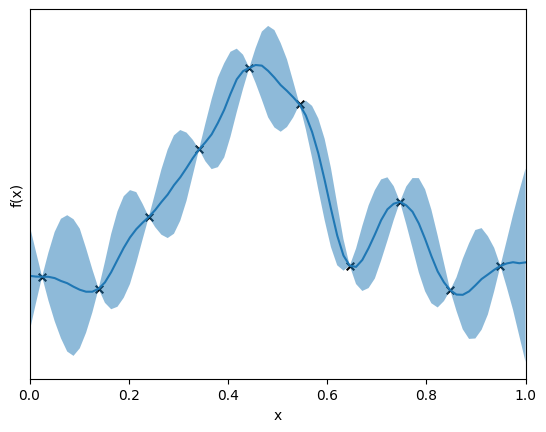

In [126]:
# standard inference 
_,_=Inference(obs_idx=obs_idx_lst[1],y_obs=y_observations[1],y_true=y_true,n_samples=2000,labels=True,draws=False,legend=False,xticks=True,n=5,alpha=0.5)

In [66]:
 #@title adjusted sampling procedure to model noise 
def Spatial_Inference(obs_idx,y_obs,y_true,noise_scale=args["noise"], n_samples=500,title=None,labels=False,draws=False,n=20,legend=True,xticks=True,alpha=0.5,av=50,m_av=True):
    start_time = time.time()
    
    samples=[]
    for i in range(n_samples//av):
        # noise model
        epsilon=dist.HalfNormal(noise_scale).sample()
        #epsilon=random.choice([s,-s])
        mean=torch.tensor(y_obs,dtype=torch.float32) #,(epsilon**2)*torch.eye(len(obs_idx))
        obs=np.array(mean+epsilon*torch.randn(len(obs_idx)))   # np.array(dist.MultivariateNormal(mean,cov).sample())
       # inference based on noisy observation
        cond_stat=jnp.zeros((N),dtype=jnp.bool_).at[obs_idx].set(1) # mask for targeting the posterior
        y=jnp.zeros((N)).at[obs_idx].set(obs) # observed values ( conditioned )
        sampling= sample_fn(jrandom.PRNGKey(0), (av,), node_ids, condition_mask=cond_stat, condition_value=y)
        s_i=sampling[...,-1,:]
        samples.append(s_i)
    end_time = time.time()
    samples=jnp.concatenate(samples, axis=0)
    if m_av==True:
        samples= mov_avg(samples)
    median_pred(samples,y_true,x[obs_idx],y_obs,title=title,labels=labels,draws=draws,n=n,legend=legend,xticks=xticks,alpha=alpha)
    #end_time = time.time()
    # Calculate the running time
    inf_time = end_time - start_time
    return samples,inf_time

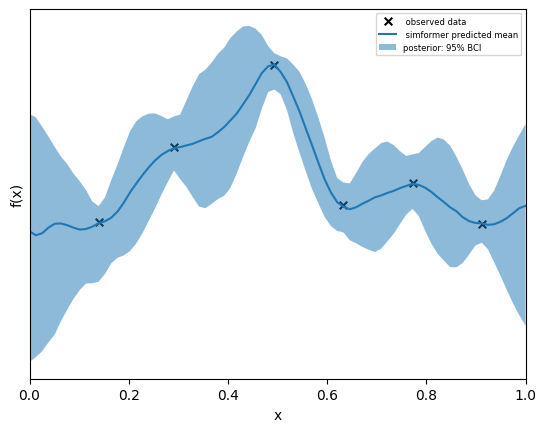

In [122]:
spatial_samples_3,_=Spatial_Inference(obs_idx=obs_idx_lst[0],y_obs=y_observations[0],noise_scale=0.25,y_true=y_true,n_samples=5000,av=100,labels=True,draws=False,legend=True,xticks=True,alpha=0.5)

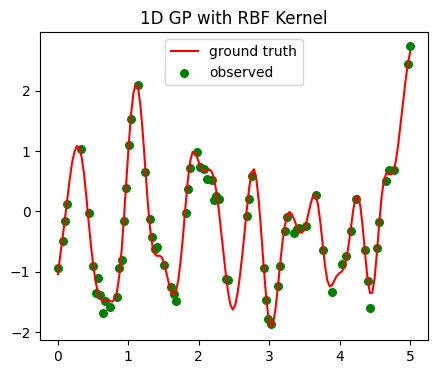

In [227]:
#@title  Synthetic ground truth & Observation
torch.manual_seed(29)   #3       #4 ,16, 22,23,29,38,40 (best),45(best),47( more fluc),90,97, 29 #60 #41 (loc 6, loc 3) #3 (loc 6,loc 3)
p=prior.sample()                # RBF-based GP prior
y_true=p
y_observations = play_simul(p,likelihood,idx=0,title="1D GP with RBF Kernel")

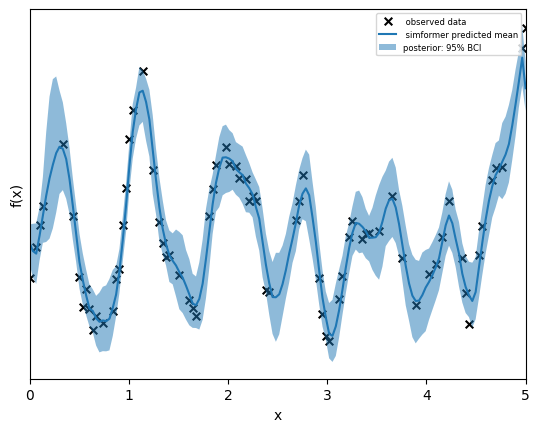

In [236]:
_,_=Spatial_Inference(obs_idx=obs_idx_lst[0],y_obs=y_observations[0],y_true=y_true,noise_scale=0.4,n_samples=1000,av=2,labels=True,draws=False,legend=True,xticks=True,alpha=0.5)

In [63]:
def median_pred(ax, samples, y_true, x_obs, y_obs, title=None, labels=False,y_ax=False, draws=False, n=20, legend=True, xticks=True, alpha=0.6):
    """
    Plot the median predictions along with the observed data on the provided axes.
    Parameters:
    ax (matplotlib.axes.Axes): The axes to plot on.
    samples (Array): Predictions from the model with shape (Batch, vector_dim).
    y_true (Array): True values for comparison.
    x_obs (Array): Observed input values (x).
    y_obs (Array): Observed output values (y).
    """
    predictions = np.array(samples)
    
    # Compute the median and percentiles
    mean_post_pred = np.median(predictions, axis=0)
    percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

    # Plot observed data
    ax.scatter(x_obs, np.array(y_obs), color="black", marker='x', label="Observed data", s=15)
    
    # Plot the predicted mean
    ax.plot(x, mean_post_pred, label="SpatFormer", alpha=1)

    # Fill the area for 95% BCI (Posterior Confidence Interval)
    ax.fill_between(x, percentiles[0, :], percentiles[1, :], alpha=alpha, interpolate=True, label="95% BCI")
    
    # If requested, plot posterior draws
    if draws:
        selected_indices = np.random.choice(predictions.shape[0], n, replace=False)
        for i, idx in enumerate(selected_indices):
            if i == 0:
                ax.plot(x, predictions[idx], color="darkgreen", alpha=0.2, label="Posterior draws")
            else:
                ax.plot(x, predictions[idx], color="darkgreen", alpha=0.2)
    
    # Customize the plot
    ax.set_xlim([0, 1])
    
    if not xticks:
        ax.set_xticks([])  # Removes x-axis ticks
    if y_ax==False:
        ax.set_yticks([])

    if title is not None:
        ax.set_title(title)

    if labels:
        ax.set_xlabel('coordinates $x$')
        ax.set_ylabel('$f(x)$',fontsize=16)
    
    if legend:
        ax.legend(fontsize=11, loc='upper right', bbox_to_anchor=(1.7, 1))



In [64]:
def median_pred2(ax, samples, y_true, x_obs, y_obs, title=None, labels=False, draws=False, n=20, legend=True, xticks=True, alpha=0.6):
    """
    Plot the median predictions along with the observed data on the provided axes.
    Parameters:
    ax (matplotlib.axes.Axes): The axes to plot on.
    samples (Array): Predictions from the model with shape (Batch, vector_dim).
    y_true (Array): True values for comparison.
    x_obs (Array): Observed input values (x).
    y_obs (Array): Observed output values (y).
    """
    predictions = np.array(samples)
    
    # Compute the median and percentiles
    mean_post_pred = np.median(predictions, axis=0)
    percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

    # Plot observed data
    ax.scatter(x_obs, np.array(y_obs), color="black", marker='x', s=15)
    
    # Plot the predicted mean
    ax.plot(x, mean_post_pred, label="MCMC ", alpha=1)

    # Fill the area for 95% BCI (Posterior Confidence Interval)
    ax.fill_between(x, percentiles[0, :], percentiles[1, :], alpha=alpha, interpolate=True, label="95% BCI")
    
    # If requested, plot posterior draws
    if draws:
        selected_indices = np.random.choice(predictions.shape[0], n, replace=False)
        for i, idx in enumerate(selected_indices):
            if i == 0:
                ax.plot(x, predictions[idx], color="darkgreen", alpha=0.2, label="Posterior draws")
            else:
                ax.plot(x, predictions[idx], color="darkgreen", alpha=0.2)
    
    # Customize the plot
    ax.set_xlim([0, 1])
    
    if not xticks:
        ax.set_xticks([])  # Removes x-axis ticks
    ax.set_yticks([])  # Removes y-axis ticks

    if title is not None:
        ax.set_title(title)

    if labels:
        ax.set_xlabel('coordinates $x$')
        ax.set_ylabel('$f(x)$',fontsize=16)
    
    if legend:
        ax.legend(fontsize=11,loc='upper right', bbox_to_anchor=(1.7, 1))



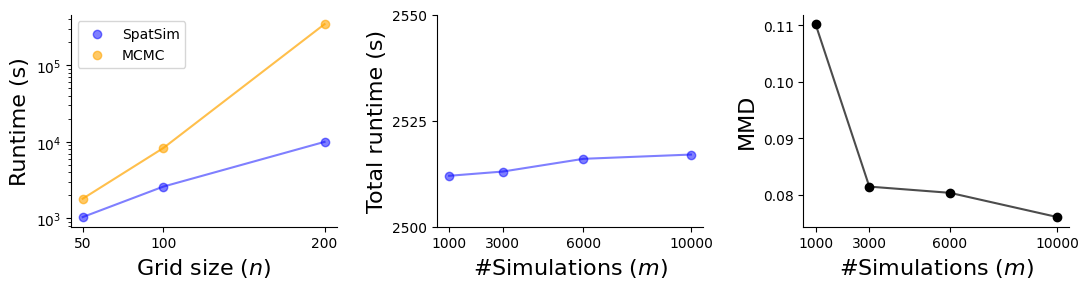

In [9]:

## Experiments results

for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
#Sim_MMD_vals=np.array([0.1102,0.0814,0.0803,0.0780])

## recorded data from experiments
x1 = [50,100,200]
y1 =np.array([15,52,70])+ np.array([1020,2540,9900]) # inf + training time for diff #observations (10000 simulations  & 2000 post samples)
y11=2*np.array([900, 4140,86400*2]) # MCMC running time (5000 post samples)
x2 = [1000, 3000, 6000, 10000]
y2 = np.array([2430,2431,2434,2435])+ 82 #training + inference time for #diff simulations (10000 post samples)
x3 = [1000, 3000, 6000, 10000]
y3 =np.array([0.1102,0.0814,0.0803,0.0760]) # MMD

# Create a figure and axes for three subplots
fig, axes = plt.subplots(1, 3, figsize=(11, 3), sharey=False)

def set_axis_color_with_alpha(ax, color, alpha=1.0):
    rgba_color = list(plt.cm.colors.to_rgba(color))  # Convert color to RGBA
    rgba_color[3] = alpha  # Set alpha (transparency)
    ax.spines['left'].set_color(rgba_color)  # Set spine color
    ax.tick_params(axis='y', colors=rgba_color)


# Plot scatter plots joined by lines in each subplot
axes[0].scatter(x1, y1, color='blue', label='SpatSim', alpha=0.5)
axes[0].plot(x1, y1, color='blue', linestyle='-', alpha=0.5)
# axes[1].set_title('(b)')
# axes[1].set_xlabel('#observed data $n_{obs}$',fontsize=18)
# axes[1].set_ylabel('Inference time (s)',fontsize=16,color='blue')
axes[0].scatter(x1, y11, color='orange', label='MCMC', alpha=0.6)
axes[0].plot(x1, y11, color='orange', linestyle='-', alpha=0.7)    
#axes[0].set_title('(a)')
axes[0].set_xlabel('Grid size $(n)$',fontsize=16)
axes[0].set_ylabel('Runtime (s)',fontsize=16)
axes[0].set_xticks(x1)
# axes[0].set_yticks(y11)
#axes[0].set_ylim([1000,25200*2+500])
#set_axis_color_with_alpha(axes[0], 'red', alpha=1)
# set_axis_color_with_alpha(axes[1], 'blue', alpha=1)
axes[0].set_yscale('log')
#axes[0].yaxis.set_major_locator(LogLocator(base=100.0, subs=None, numticks=10))

axes[1].scatter(x2, y2,color='blue', alpha=0.5)
axes[1].plot(x2, y2,color='blue', linestyle='-', alpha=0.5)
#axes[1].set_title('(b)')
axes[1].set_xlabel('#Simulations $(m)$',fontsize=16)
axes[1].set_ylabel('Total runtime (s)',fontsize=16)
axes[1].set_yticks([2500,2525,2550])
axes[1].set_xticks(x2)
#axes[1].set_ylim([2510,2530])
#axes[1].set_yscale('log')
#set_axis_color_with_alpha(axes[2], 'blue', alpha=1)

axes[2].scatter(x3, y3, color='black')
axes[2].plot(x3, y3, color='black', linestyle='-', alpha=0.7)
#axes[2].set_title('(c)')
axes[2].set_xlabel('#Simulations $(m)$',fontsize=16)
axes[2].set_ylabel('MMD',fontsize=16)
axes[2].set_xticks(x3)
# Add a legend to each subplot

axes[0].legend()
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
# Adjust spacing between subplots
plt.tight_layout()

# Show the plot loc='upper left', bbox_to_anchor=(1, 1)
plt.show()


In [5]:
#fig.savefig('last_compile_1D_res_SpatSim.pdf', bbox_inches='tight', format='pdf')

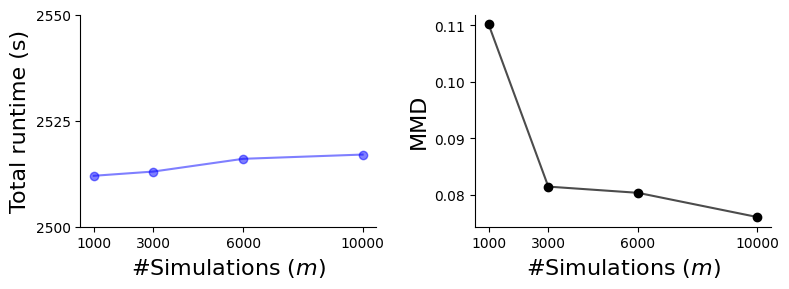

In [19]:
# Create a figure and axes for three subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=False)

def set_axis_color_with_alpha(ax, color, alpha=1.0):
    rgba_color = list(plt.cm.colors.to_rgba(color))  # Convert color to RGBA
    rgba_color[3] = alpha  # Set alpha (transparency)
    ax.spines['left'].set_color(rgba_color)  # Set spine color
    ax.tick_params(axis='y', colors=rgba_color)


axes[0].scatter(x2, y2,color='blue', alpha=0.5)
axes[0].plot(x2, y2,color='blue', linestyle='-', alpha=0.5)
#axes[1].set_title('(b)')
axes[0].set_xlabel('#Simulations $(m)$',fontsize=16)
axes[0].set_ylabel('Total runtime (s)',fontsize=16)
axes[0].set_yticks([2500,2525,2550])
axes[0].set_xticks(x2)
#axes[1].set_ylim([2510,2530])
#axes[1].set_yscale('log')
#set_axis_color_with_alpha(axes[2], 'blue', alpha=1)

axes[1].scatter(x3, y3, color='black')
axes[1].plot(x3, y3, color='black', linestyle='-', alpha=0.7)
#axes[2].set_title('(c)')
axes[1].set_xlabel('#Simulations $(m)$',fontsize=16)
axes[1].set_ylabel('MMD',fontsize=16)
axes[1].set_xticks(x3)
# Add a legend to each subplot

# axes[0].legend()
for ax in axes:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [20]:
# fig.savefig('last_runt_Sim.pdf', bbox_inches='tight', format='pdf')

In [15]:
# fig.savefig('last_runt_gridsize.pdf', bbox_inches='tight', format='pdf')

In [16]:
## Load MCMC samples for comparison 
# with open('SIM_experiments_last1.pkl', 'rb') as f:
#      SIM_experiments_last1=pickle.load(f)

# with open("case_improv_6.pkl","rb") as f:
#     case_improv_6=pickle.load(f)
# with open("case_improv_10.pkl","rb") as f:
#     case_improv_10=pickle.load(f)
# with open("/kaggle/input/last-result/MCMC_samples.pkl", 'rb') as file:
#        m= pickle.load(file)
    
# MCMC_samples=[m[1],m[0]]


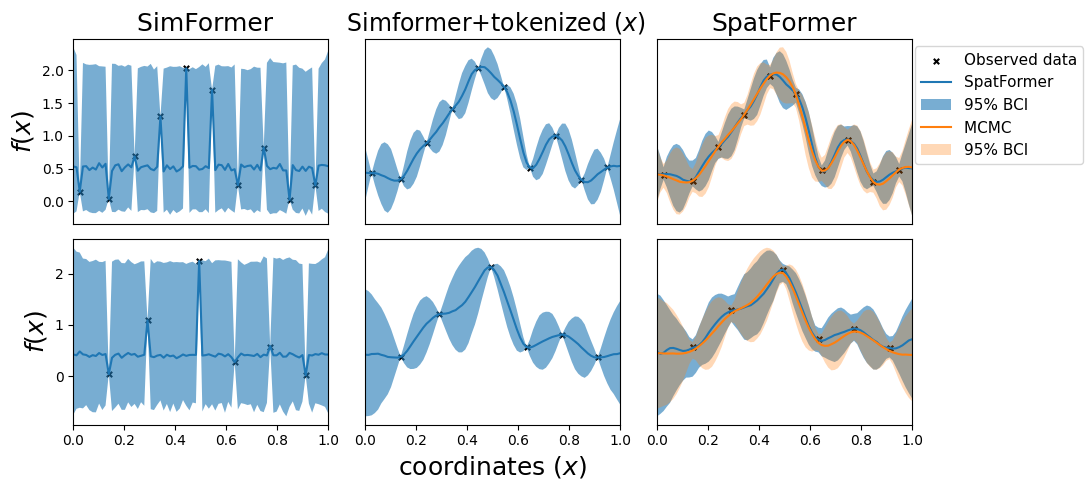

In [66]:
#@title Simformer vs spatformer vs adjusted spatformer 
fig, axes = plt.subplots(2, 3, figsize=(11, 5), sharey=False)

for i in range(3):
    if i==0:
        y_ax=True
    else:
        y_ax=False
    median_pred(axes[1,i],case_improv_6[i],y_true=y_true, x_obs=x[obs_idx_lst[0]], y_obs=y_observations[0], title=None, labels=False, draws=False, legend=False, xticks=True,y_ax=y_ax)
    median_pred(axes[0,i],case_improv_10[i],y_true=y_true, x_obs=x[obs_idx_lst[1]], y_obs=y_observations[1], title=None, labels=False, draws=False, legend=False,xticks=False,y_ax=y_ax)
median_pred2(axes[0,2],MCMC_samples[1],y_true=y_true, x_obs=x[obs_idx_lst[1]], y_obs=y_observations[1], title=None, labels=False, draws=False, legend=True,xticks=False,alpha=0.3)
median_pred2(axes[1,2],MCMC_samples[0]-0.09,y_true=y_true, x_obs=x[obs_idx_lst[0]], y_obs=y_observations[0], title=None, labels=False, draws=False, legend=False,xticks=True, alpha=0.3)
axes[0,0].set_title(' SimFormer',fontsize=18)
axes[0,1].set_title(' Simformer+tokenized $(x)$',fontsize=17)
axes[0,2].set_title('SpatFormer',fontsize=18)
#axes[1,0].set_xlabel('coordinates $x$',fontsize=16)
axes[1,1].set_xlabel('coordinates $(x)$',fontsize=18)
#axes[1,2].set_xlabel('coordinates $x$',fontsize=16)
axes[0,0].set_ylabel('$f(x)$',fontsize=18)
axes[1,0].set_ylabel('$f(x)$',fontsize=18)
#axes[0,0].set_ylim([0,2])
plt.tight_layout()
plt.show()   

In [67]:
# fig.savefig('last_compile_1D_abla_std_perform_SpatSim.pdf', bbox_inches='tight', format='pdf')

In [175]:
# fig.savefig('last_compile_1D_abla_std_perform.pdf', bbox_inches='tight', format='pdf')

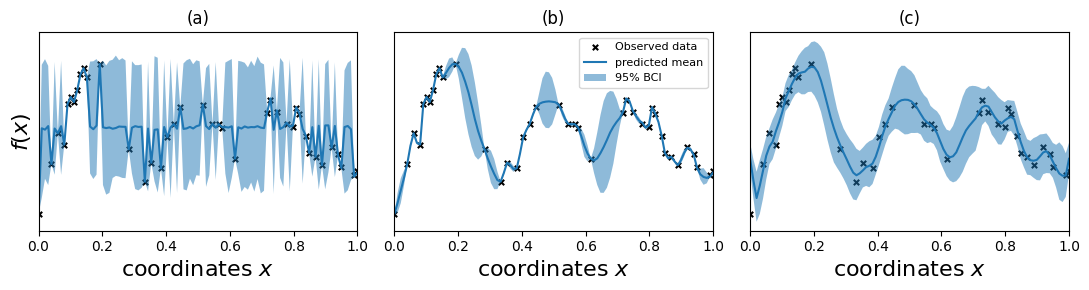

In [42]:
#@title Ablation study : Simformer vs simformer + designed tokenization vs SpatFormer

# Load samples obtain from previously trained model 
# with open('ablation_study.pkl', 'rb') as f:
#     ablation_study= pickle.load(f)
# samples_1,samples_2,samples_3=ablation_study

fig, axes = plt.subplots(1, 3, figsize=(11, 3), sharey=True)
median_pred(axes[0], samples_1,y_true=y_true, x_obs=x[obs_idx_lst[3]], y_obs=y_observations[3], title=None, labels=True, draws=False, legend=False)
median_pred(axes[1], samples_2,y_true=y_true, x_obs=x[obs_idx_lst[3]], y_obs=y_observations[3], title=None, labels=False, draws=False, legend=True)
median_pred(axes[2], samples_3,y_true=y_true, x_obs=x[obs_idx_lst[3]], y_obs=y_observations[3], title=None, labels=False, draws=False,legend=False)
axes[0].set_title('(a)')
axes[1].set_title('(b)')
axes[2].set_title('(c)')
axes[0].set_xlabel('coordinates $x$',fontsize=16)
axes[1].set_xlabel('coordinates $x$',fontsize=16)
axes[2].set_xlabel('coordinates $x$',fontsize=16)
plt.tight_layout()
plt.show()


In [43]:
# fig.savefig('compile_1D_abla_stdy.pdf', bbox_inches='tight', format='pdf')

# Comparative Study

In [16]:
# with open('/kaggle/input/mcmc-exp-results/mcmc_results.pkl', 'rb') as f:
#     mcmc_results= pickle.load(f) # list of mcmc experiments results (4 experiments) : (pp_mcmc_samples, inference time) 

# with open('/kaggle/working/Sim_experiments_results.pkl', 'rb') as f:
#      Sim_exp_results= pickle.load(f) # (sim_samples,inf_time,elapsed_time,train_loss)

# with open("/kaggle/working/sim_inf_time.pkl", 'rb') as file:
#          sim_inf_time= pickle.load(file)
# with open('Sim_MMD_vals.pkl', 'rb') as f:
#    Sim_MMD_6pts_vals=pickle.load(f) # list of mcmc experiments results (4 experiments) : (pp_mcmc_samples, inference time) 


# #mcmc inference time
# mcmc_inf_time=[]
# for i in range(len(mcmc_results)): 
#      mcmc_inf_time.append(mcmc_results[i][1])

# # #Simformer training time
# training_time=[]
# for i in range(len(Sim_exp_results)):
#      training_time.append(Sim_exp_results[i][2])

# num_simulations=[1000,3000,6000,10000]
# # num_samples=[1000,3000,6000,10000]
# # sim_inf_time=[]
# # for n in num_samples:
# #     _,inf_time=Inference(obs_idx=obs_idx_lst[0],y_obs=y_observations[0],y_true=y_true,n_samples=n,labels=True,draws=True,legend=False,xticks=True,alpha=0.5)
# #     sim_inf_time.append(inf_time)

# Evaluation Metrics

In [37]:
#@title Maximum Mean Discrepancy ( MMD ) / Classifier two-sample test ( c2st )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def MMD(x, y, kernel= "rbf"):
    """Emprical maximum mean discrepancy. The lower the result
       the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":
      
        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
      

    return torch.mean(XX + YY - 2. * XY)


def c2st_scores(
    X: Tensor,
    Y: Tensor,
    seed: int = 1,
    n_folds: int = 5,
    metric: str = "accuracy",
    z_score: bool = False,
    noise_scale: Optional[float] = None,
    verbosity: int = 0,
    clf_class: Any = RandomForestClassifier,
    clf_kwargs: Optional[Dict[str, Any]] = None,
) -> Tensor:

    if z_score:
        X_mean = torch.mean(X, dim=0)
        X_std =torch.std(X, dim=0)
        X = (X - X_mean) / X_std
        Y = (Y - X_mean) / X_std

    if noise_scale is not None:
        X += noise_scale * torch.randn(X.shape)
        Y += noise_scale * torch.randn(Y.shape)

    X = X.cpu().numpy()
    Y = Y.cpu().numpy()

    clf = clf_class(random_state=seed, **clf_kwargs or {})

    # prepare data
    data = np.concatenate((X, Y))
    # labels
    target = np.concatenate((np.zeros((X.shape[0],)), np.ones((Y.shape[0],))))

    shuffle = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    scores = cross_val_score(
        clf, data, target, cv=shuffle, scoring=metric, verbose=verbosity
    )
    scores = np.asarray(np.mean(scores)).astype(np.float32)
    value = torch.from_numpy(np.atleast_1d(scores))
    return value

In [38]:
# def metrics( mcmc_id=1, sim_inf=SIM_experiments_last2,kernel= "rbf"):  #10pts
#     Sim_MMD_vals=[]
#     #Sim_C2ST_vals=[]
#     for i in range(len(num_simulations)):
#         mcmc_samples=torch.tensor(MCMC_samples[mcmc_id])  
#         sim_samples=torch.tensor(np.array(sim_inf[i]))
#         mmd=MMD(mcmc_samples,sim_samples,kernel=kernel)
#         #c2st=c2st_scores(mcmc_samples,sim_samples)
#         Sim_MMD_vals.append(mmd)
#        # Sim_C2ST_vals.append(c2st)
#     return   Sim_MMD_vals          #,Sim_C2ST_vals


# with open("/kaggle/working/SIM_experiments_last1.pkl","rb") as f:
#     SIM_experiments_last1=pickle.load(f)
    
# Sim_MMD_vals=metrics( mcmc_id=1, sim_inf=SIM_experiments_last1,kernel="multiscale")

In [126]:

# graph=["mcmc_sim_inftime","mcmc_sim_train_inftime","mcmc_sim_mmd","mcmc_sim_visual"]

# y1,y2,y3,y4=np.array(mcmc_inf_time),np.array(sim_inf_time),np.array(training_time),np.array(Sim_MMD_vals)
# def plot_function(res,title,MCMC_samples=None,x=np.array(num_simulations) ):
#     # Inference time vs #samples
#      if res=="mcmc_sim_inftime":
#         fig=plt.figure(figsize=(5, 3))
#         plt.plot(x, y1, linestyle='-',color='black')
#         plt.scatter(x, y1, color='r', label='mcmc-based inference')
#         plt.plot(x, y2, linestyle='-', color='black')
#         plt.scatter(x, y2, color='b',  label='Simformer-based inference')
#         # Set custom x-axis ticks
#         plt.xticks(x)
#         # Add labels and title
#         plt.yscale('log')
#         plt.xlabel('number of samples')
#         plt.ylabel('time (s)')
#         plt.title(title)
#         plt.legend()
#         plt.grid(False)
#         plt.show()
#      if res=="mcmc_sim_train_inftime":
#          # Create the figure and axis
#         fig, ax1 = plt.subplots(figsize=(6, 3))
#         # Plot y1 on the primary y-axis
#         ax1.plot(x, y1, linestyle='-', color='red', marker='o', label='MCMC')
#         ax1.set_xticks(x)
#         ax1.set_xticklabels(x)
#         ax1.set_xlabel('Number of samples')
#         ax1.set_yscale('log')
#         ax1.set_ylabel('Inference time (s)', color='red')
        
#         # Color the y1 axis tick labels
#         for label in ax1.get_yticklabels():
#             label.set_color('red')
        
#         # Create a secondary y-axis for y2
#         ax2 = ax1.twinx()
#         ax2.plot(x, y2+2500, linestyle='-', color='blue', marker='s', label='Simformer')
#         ax2.set_ylabel('Inference time (s)', color='blue')
        
#         # Color the y2 axis tick labels
#         for label in ax2.get_yticklabels():
#             label.set_color('blue')
        
#         # Add grid and title
#         ax1.grid(True, linestyle='--', alpha=0.6)
        
#         # Add legends
#         fig.legend(loc='upper left', bbox_to_anchor=(0.2, 0.95))
        
#         # Save and show the plot
#         plt.tight_layout()
#         # plt.savefig('comparison_plot.pdf', bbox_inches='tight', format='pdf')
#         plt.show()
  
#      if res=="mcmc_sim_mmd":
#         fig=plt.figure(figsize=(6, 3))
#         plt.plot(x, y4, linestyle='-', color='black')
#         plt.scatter(x, y4, color='black')
#         #plt.ylim([0.175,0.185])
#         # Set custom x-axis ticks
#         plt.xticks(x)
#         # Add labels and title
#         plt.xlabel('Number of simulations')
#         plt.ylabel('MMD')
#         plt.title(title)
#         plt.legend()
#         plt.tight_layout()
#         plt.grid(False)
#         plt.show()
#      if res=="mcmc_sim_visual":
#          fig = plt.figure(figsize=(10,3))
#          if MCMC_samples != None:
#                 for i in range(2):
#                         legend=False
#                         labels=True
#                         if i+1==2:
#                             legend=True
#                             labels=False
#                         fig.add_subplot(1,2,i+1)
                        
#                         median_pred2(MCMC_samples[i],y_obs=y_observations[i],y_true=y_true,x_obs=x[obs_idx_lst[i]],title=None,labels=labels,draws=False,n=20,legend=legend,alpha=0.4)
#                         _,_=Inference(obs_idx=obs_idx_lst[i],y_obs=y_observations[i],y_true=y_true,n_samples=10,labels=labels,draws=False,legend=legend)
#      return fig

#fig=plot_function(res=graph[2],title=None,MCMC_samples=MCMC_samples)

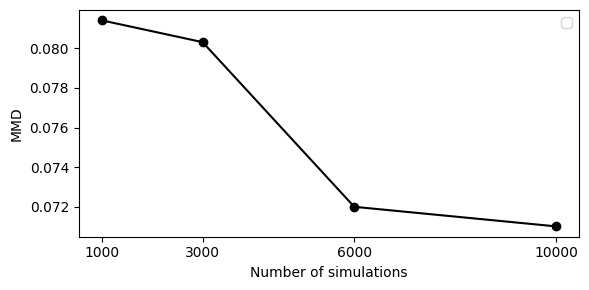

In [127]:
#fig=plot_function(res=graph[2],title=None,MCMC_samples=MCMC_samples)
# fig.savefig('MMD_rbf_fig.eps', bbox_inches='tight', format='eps')
# fig.savefig('MMD_rbf_fig.pdf', bbox_inches='tight', format='pdf')

# 2D GP inference

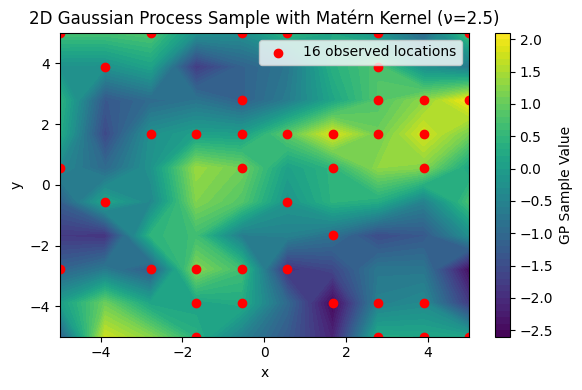

In [21]:
# Step 1: Generate 2D grid of points
N =args["dimensionality"]  # Number of points along each dimension

x = torch.linspace(args["bound"][0], args["bound"][1], N)
y = torch.linspace(args["bound"][0], args["bound"][1], N)
X_grid, Y_grid = torch.meshgrid(x, y)
X = torch.stack([X_grid.flatten(), Y_grid.flatten()], dim=1)  # Shape (N^2, 2)

# Function for Matérn Kernel
def matern_kernel(ls=0.8, X=X, X_prime=X, nu=2.5,variance=1,jitter=1.0e-6):
    # Implementation for Matern Kernel (ν=2.5)
    dist = torch.cdist(X, X_prime, p=2) / ls
    sqrt_5_dist = torch.sqrt(torch.tensor(5.0)) * dist
    kernel = variance * (1 + sqrt_5_dist + (5.0/3.0) * dist**2) * torch.exp(-sqrt_5_dist)
    return kernel + jitter * torch.eye(kernel.shape[0])


torch.manual_seed(7)  # 6 (16 obs points)

# Step 2: Compute the covariance matrix using the Matérn kernel
nu = 2.5  # Smoothness parameter
length_scale = 1  # Length scale
variance = 1.0  # Variance
cov_matrix = matern_kernel(ls=length_scale, X=X, X_prime=X, nu=nu, variance=variance)

# Step 3: Generate GP samples (mean zero, covariance from Matérn kernel)
mean = torch.zeros(N * N)  # Zero mean for each point in the 2D space
gp = MultivariateNormal(mean, covariance_matrix=cov_matrix)

# Sample from the GP
samples = gp.sample((1,)).reshape(N, N)  # Generate 1 sample and reshape to 2D grid


# Step 4: Select "num_observed" random points from the sample grid and add noise to their values

def get_observed_info(num_pts=args["n_obs_pts"][0],noise=args["noise"]):
    torch.manual_seed(7) #6 
    selected= torch.randperm(N * N)[:num_pts]  # Indices of "num_pts" random points
    noise = torch.randn(num_pts) * noise  # Add noise to the sample values
    noisy_samples = samples.flatten()  # Flatten the sample grid
    noisy_samples[selected] += noise  # Add noise to the selected points
    locations = X[selected]           # locations of observed outcomes 
    obs_idx=selected.numpy()
    x_obs=locations.numpy()
    y_obs=noisy_samples[obs_idx].numpy()
    return obs_idx,x_obs,y_obs,locations,selected

_,_,_,locations,selected=get_observed_info(num_pts=args["n_obs_pts"][1])

# selected_16 = torch.randperm(N * N)[:16]  # Indices of 16 random points
# noise = torch.randn(16) * 0.1  # Add noise to the sample values
# noisy_samples = samples.flatten()  # Flatten the sample grid
# noisy_samples[selected_16] += noise  # Add noise to the selected points


# Step 6: Plot the GP sample with the noisy points and the 8 random points
plt.figure(figsize=(6, 4))  
plt.contourf(X_grid.numpy(), Y_grid.numpy(), samples.numpy(), cmap='viridis', levels=50)
plt.colorbar(label='GP Sample Value')

# Mark noisy points on the grid
plt.scatter(locations[:, 0], locations[:, 1], color='r', label='16 observed locations', marker='o')

# Ensure the plot fits the map
plt.xlim(args["bound"])
plt.ylim(args["bound"])
plt.title('2D grid')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()



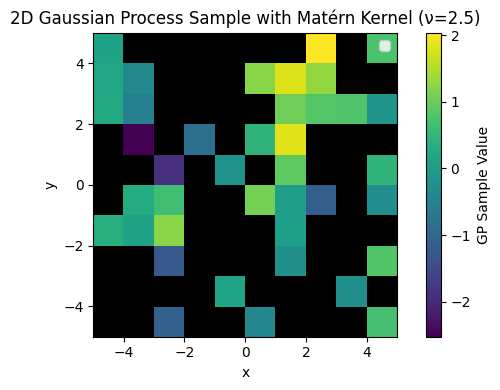

In [22]:
# Step 3: Create a mask for non-selected locations
mask = np.ones_like(samples.numpy(), dtype=bool)  # Initialize mask as True (all points masked)
mask = mask.flatten()  # Flatten the mask
mask[selected.numpy()] = False  # Unmask selected points
masked_samples = np.ma.array(samples.numpy(), mask=mask.reshape(N, N))  # Mask the non-selected points

# Step 4: Plot the masked GP sample using imshow
plt.figure(figsize=(6, 4))  # Increase figure size for better fitting

# Create a colormap and set the color for masked values (black)
cmap = plt.cm.viridis
cmap.set_bad(color='black')  # Set color for masked values

# Use imshow to plot, with masked values in blac
extent=(args["bound"][0], args["bound"][1], args["bound"][0], args["bound"][1])

plt.imshow(masked_samples, cmap=cmap, extent=extent, origin='lower')
plt.colorbar(label='GP Sample Value')
# Customize plot appearance
plt.xlim(args["bound"])
plt.ylim(args["bound"])
plt.title('2D Gaussian Process Sample with Matérn Kernel (ν=2.5)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()


In [15]:
#@title build condition masks
def build_mask(obs_idx_lst,N=len(x)):
  """
  N (int): sequence length
  obs_idx_lst (list): list of indices/locations of the observed data points
  """
  masks_list=[]
  masks_list=[]
  for i in range(len(obs_idx_lst)):
    masks_list.append(jnp.zeros((N),dtype=jnp.bool_).at[obs_idx_lst[i]].set(1))
  return jnp.array(masks_list)

def get_list(n=len(args["n_obs_pts"]) ):
    obs_idx_lst,x_obs_lst,y_obs_lst=[],[],[]
    for i in range(n):
        obs_idx,x_obs,y_obs,_,_=get_observed_info(num_pts=args["n_obs_pts"][i])
        obs_idx_lst.append(obs_idx)
        x_obs_lst.append(x_obs)
        y_obs_lst.append(y_obs)
    return obs_idx_lst,x_obs_lst,y_obs_lst
        
# Build conditioning masks       
obs_idx_lst,x_obs_lst,y_obs_lst=get_list(n=len(args["n_obs_pts"]))
masks_list=build_mask(obs_idx_lst=obs_idx_lst,N=N*N)

In [72]:
#@title Likelihood  and Prior ( Gaussian Process )
class CustomPrior(Distribution):
    def __init__(self, low, high,cov_func):
        super().__init__()
        self.dist1 = dist.Uniform(low=low, high=high) # prior over lenghtscale
        #self.dist2 = dist.HalfNormal(scale)
        self.cov_func = cov_func  # Function to compute covariance matrix

    def sample(self, sample_shape=torch.Size()):
        sample1 = self.dist1.sample(sample_shape) # ls
        #sample2 = self.dist2.sample(sample_shape) # epsilon
        # Calculate covariance matrix using the sample from dist1
        if sample1.dim()==0:
          K= self.cov_func(variance=sample1)
          dist3 = dist.MultivariateNormal(loc=torch.zeros(K.shape[0]), covariance_matrix=K)
          sample3=dist3.sample()
          samples=sample3
        else:
          sample_list=[]
          for var in sample1:
            K= self.cov_func(variance=var)   #GP_kernel
            # Create dist3 using the calculated covariance matrix
            dist3 = dist.MultivariateNormal(loc=torch.zeros(K.shape[0]), covariance_matrix=K)
          # Sample from dist3
            sample_list.append(dist3.sample())
          # combine sample
          sample3= torch.stack(sample_list)

            # Concatenate sample1, sample2, and sample3 along the last dimension
          samples = sample3
        return samples

    def log_prob(self):
        pass

### define the prior and the Model simulator model
## Prior
prior=CustomPrior(low=0.1, high=1, cov_func=matern_kernel)                 # GP priors with RBF kernel

## Martern prior
K = matern_kernel(ls=0.8)
mean = torch.zeros(N*N)  # Zero mean
prior2= MultivariateNormal(mean, covariance_matrix=cov_matrix)

## Likelihood
def likelihood(theta):
  epsilon=dist.HalfNormal(0.1).sample()
  if theta.dim()==1:
    f_gp=theta                             #[np.array(obs_idx)]
  else:
    f_gp=(theta[:,:]).squeeze()             #np.array(obs_idx)

  mean,cov=f_gp,(epsilon**2)*torch.eye(len(f_gp))
  y=dist.MultivariateNormal(mean,cov).sample()
  # y= f_gp + epsilon*torch.randn_like(f_gp)
  return y.unsqueeze(0)


/opt/conda/lib/python3.10/site-packages/torch/distributions/distribution.py:55: UserWarning: <class '__main__.CustomPrior'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [47]:
#@title Simulate synthetic data for training ( 20000 simulated samples).
theta, _ = simulate_for_sbi(likelihood, proposal=prior2, num_simulations=10000) # theta== Gaussian Process sample, y= likelihood sample

#
data=jnp.array((np.array(theta.unsqueeze(-1))))
nodes_max = data.shape[1]                       # each variable is consider a node of a graph
node_ids = jnp.arange(nodes_max)                # node Id ( position )
print(f'data shape:{data.shape}')               # (Batch_dim, node_max ,1)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

data shape:(10000, 100, 1)


In [48]:
# # load model params
# with open("/kaggle/working/tree_params_2D_Martern_kernel_recent.pkl", 'rb') as file:
#      params= pickle.load(file)

In [49]:
# Set random key
key = jax.random.PRNGKey(args["key"])
print(jax.devices())  # available device

[cuda(id=0), cuda(id=1)]


In [50]:
#@title build the Embedding modules + Transformer architecture

#setup the latent dimensions
dim_value = args["dim_value"]      # Size of the value embedding
dim_id =  args["dim_id"]         # Size of the node id embedding
dim_condition = args["dim_condition"]  # Size of the condition embedding
time_dim=args["time_emb"]           # time embedding dimension


def model(t: Array, x: Array, node_ids: Array, condition_mask:Array, edge_mask: Optional[Array]=None):
    """Simplified Simformer model.

    Args:
        t (Array): Diffusion time
        x (Array): Value of the nodes
        node_ids (Array): Id of the nodes
        condition_mask (Array): Condition state of the nodes
        edge_mask (Array, optional): Edge mask. Defaults to None.
    Returns:
        Array: Score estimate of p(x_t)
    """

    batch_size, seq_len, _ = x.shape
    condition_mask = condition_mask.astype(jnp.bool_).reshape(-1,seq_len, 1)
    node_ids = node_ids.reshape(-1,seq_len)
    t = t.reshape(-1,1, 1)

    # Diffusion time embedding net (here we use a Gaussian Fourier embedding)
    embedding_time = GaussianFourierEmbedding(time_dim)  # Time embedding method
    time_embeddings = embedding_time(t)

    # Tokinization part --------------------------------------------------------------------------------

    embedding_net_value = lambda x: jnp.repeat(x, dim_value, axis=-1)    # Value embedding net ( we just repeat the value)
    embedding_net_id = hk.Embed(nodes_max, dim_id, w_init=hk.initializers.RandomNormal(stddev=3.))   # Node id embedding nets (we use a learnable random embedding vector)
    condition_embedding = hk.get_parameter("condition_embedding", shape=(1,1,dim_condition), init=hk.initializers.RandomNormal(stddev=0.5)) #Condition embedding (here we use a learnable random embedding vector)
    condition_embedding = condition_embedding * condition_mask # If condition_mask is 0, then the embedding is 0, otherwise it is the condition_embedding vector
    condition_embedding = jnp.broadcast_to(condition_embedding, (batch_size, seq_len, dim_condition))

    # Embed inputs and broadcast
    value_embeddings = embedding_net_value(x)
    id_embeddings = embedding_net_id(node_ids)
    value_embeddings, id_embeddings = jnp.broadcast_arrays(value_embeddings, id_embeddings)

    # Concatenate embeddings (alternatively we can also add instead of concatenating)
    x_encoded = jnp.concatenate([value_embeddings,id_embeddings, condition_embedding], axis=-1) #id_embeddings,

    # Transformer part --------------------------------------------------------------------------------
    model = Transformer(num_heads=2, num_layers=2, attn_size=10, widening_factor=3)

    # Encode -  use a transformer to transform the tokenized inputs into a latent representation
    h = model(x_encoded, context=time_embeddings, mask=edge_mask)

    # Decode - here we just use a linear layer to get the score estimate (we scale the output by the marginal std dev)
    out = hk.Linear(1)(h)
    out = output_scale_fn(t, out) # SDE dependent output scaling
    return out

In [177]:
#@title Configuration: Loss/ model/ training setting
#@title 2) Setting up the diffusion process
# VESDE
T = args["T"]
T_min = args["T_min"]
sigma_min = args["sigma_min"]
sigma_max = args["sigma_max"]
p0 = Independent(Empirical(data), 1) # Empirical distribution of the data
sde = VESDE(p0, sigma_min=sigma_min , sigma_max=sigma_max)


# Scaling fn for the output of the score model
def output_scale_fn(t, x):
    scale = jnp.clip(sde.marginal_stddev(t, jnp.ones_like(x)), 1e-2, None)
    return (1/scale * x).reshape(x.shape)


#@title  Initialize the model .( as require in Haiku )
# Init function initializes the parameters of the model, model_fn is the actual model function (which takes the parameters as first argument)
init, model_fn= hk.without_apply_rng(hk.transform(model))
params=init(key, jnp.ones(data.shape[0]), data, node_ids, jnp.zeros_like(node_ids))
# view total number of parameters and their shapes
print("Total number of parameters: ", jax.tree_util.tree_reduce(lambda x,y: x+y, jax.tree_map(lambda x: x.size, params)))
jax.tree_util.tree_map(lambda x: x.shape, params) # Here we can see the shapes of the parameters



#@title  The loss function
def weight_fn(t:Array):
    # MLE weighting
    return jnp.clip(sde.diffusion(t, jnp.ones((1,1,1)))**2, 1e-4)

def marginalize(rng: PRNGKey, edge_mask: Array):
    # Simple function that marginializes out a single node from a adjacency matrix of a graph.
    idx = jax.random.choice(rng, jnp.arange(edge_mask.shape[0]), shape=(1,), replace=False)
    edge_mask = edge_mask.at[idx, :].set(False)
    edge_mask = edge_mask.at[:, idx].set(False)
    edge_mask = edge_mask.at[idx, idx].set(True)
    return edge_mask

def loss_fn(params: dict, key: PRNGKey,batch_size:int= 1024):

    rng_time, rng_sample, rng_data, rng_condition, rng_edge_mask1, rng_edge_mask2 = jax.random.split(key, 6)

    # Generate data and random times
    times = jax.random.uniform(rng_time, (batch_size, 1, 1), minval=T_min, maxval=1.0)
    batch_xs = generator(rng_data, batch_size) # n, T_max, 1

    # Node ids (can be subsampled but here we use all nodes)
    ids = node_ids

    ## Condition mask -> randomly condition on some data.
    #condition_mask = jax.random.bernoulli(rng_condition, 0.10, shape=(batch_xs.shape[0], batch_xs.shape[1]))
    # condition_mask_all_one = jnp.all(condition_mask, axis=-1, keepdims=True)
    # condition_mask *= condition_mask_all_one # Avoid conditioning on all nodes -> nothing to train...
    #condition_mask = condition_mask[..., None]

    #Alternatively  set the condition mask manually to specific conditional distributions.
    index = jax.random.randint(rng_condition, (), 0, len(masks_list))
    cond= masks_list[index]
    #cond=jnp.zeros((N*N),dtype=jnp.bool_).at[obs_idx].set(1) # Posterior mask
    condition_mask= jnp.tile(jnp.expand_dims(cond,axis=0), (batch_xs.shape[0], 1))  # Replicate along the first dimension

    # one can also structure the base mask!
    #edge_mask = jnp.ones((4*batch_size//5, batch_xs.shape[1],batch_xs.shape[1]), dtype=jnp.bool_) # Dense default mask

    # Optional: Include marginal consistency
    # marginal_mask = jax.vmap(marginalize, in_axes=(0,None))(jax.random.split(rng_edge_mask1, (batch_size//5,)), edge_mask[0])
    # edge_masks = jnp.concatenate([edge_mask, marginal_mask], axis=0)
    # edge_masks = jax.random.choice(rng_edge_mask2, edge_masks, shape=(batch_size,), axis=0) # Randomly choose between dense and marginal mask

    # Forward diffusion, do not perturb conditioned data
    # Will use the condition mask to mask to prevent adding noise for nodes that are conditioned.
    loss = denoising_score_matching_loss(params, rng_sample, times, batch_xs, condition_mask, model_fn= model_fn, mean_fn=sde.marginal_mean, std_fn = sde.marginal_stddev, weight_fn=weight_fn,node_ids=ids, condition_mask=condition_mask) #, edge_mask=edge_masks
    return loss



#@title training : designed  to leverage parallel computation on multiple devices  ( GPU )
optimizer = optax.adam(1e-3)        # optimizer
opt_state = optimizer.init(params)  # initial params state

@partial(jax.pmap, axis_name="num_devices")                                 # parallelize computations
def update(params, rng, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, rng)                  # compute loss and gradients

    loss = jax.lax.pmean(loss, axis_name="num_devices")                     # aggregate loss accross devices ( mean )
    grads = jax.lax.pmean(grads, axis_name="num_devices")                   # aggregate gradients accross devices ( mean )

    updates, opt_state = optimizer.update(grads, opt_state, params=params)  #
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state



#title replicate the model params and optimizer state across available devices for data-parallel computation
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)
replicated_opt_state = jax.tree_map(lambda x: jnp.array([x] * n_devices), opt_state)



#@title define data generator:
def generator(key: PRNGKey, n:int):
    key1,key2= jrandom.split(key,2)
    theta, y = simulate_for_sbi(likelihood, proposal=prior2, num_simulations=n)
    return jnp.array((np.array(theta.unsqueeze(-1))))


Total number of parameters:  47714


In [178]:
#training loop
start_time=time.time()
key = jrandom.PRNGKey(2)
train_loss=[]
epochs=20 #args["epoch"]
for epoch in range(epochs):
    l = 0
    for i in range(args["inner_loop"]):
        key, subkey = jrandom.split(key)
        loss, replicated_params, replicated_opt_state = update(replicated_params, jax.random.split(subkey,  (n_devices,)), replicated_opt_state)
        l += loss[0] /args["inner_loop"]
    train_loss.append(l)
    #if epoch % 10==0:
    print(f"Epoch: {epoch} | Loss: {l}")
end_time=time.time()
elapsed_time = end_time - start_time
print(f"Running time: {elapsed_time:.4f} seconds")

#get updated params (tree object ) for inference
params= jax.tree_map(lambda x: x[0], replicated_params)

#training_history(train_loss)

Running 1024 simulations.:   0%|          | 0/1024 [00:00<?, ?it/s]

Epoch: 0 | Loss: 942.4229125976562
Epoch: 1 | Loss: 908.3511352539062
Epoch: 2 | Loss: 901.7265625
Epoch: 3 | Loss: 903.6544799804688
Epoch: 4 | Loss: 904.00634765625
Epoch: 5 | Loss: 895.4014892578125
Epoch: 6 | Loss: 894.7831420898438
Epoch: 7 | Loss: 894.6560668945312
Epoch: 8 | Loss: 894.6593017578125
Epoch: 9 | Loss: 889.69921875
Epoch: 10 | Loss: 888.309814453125
Epoch: 11 | Loss: 885.718017578125
Epoch: 12 | Loss: 883.2862548828125
Epoch: 13 | Loss: 890.34423828125
Epoch: 14 | Loss: 878.5078125
Epoch: 15 | Loss: 880.5048217773438
Epoch: 16 | Loss: 877.7752075195312
Epoch: 17 | Loss: 875.7658081054688
Epoch: 18 | Loss: 875.7924194335938
Epoch: 19 | Loss: 874.0801391601562
Running time: 3423.3277 seconds


In [97]:
# with open('tree_params_2D_Martern_kernel_recent.pkl', 'wb') as f:
#      pickle.dump( params, f)

In [179]:
#@title Sampling  process

condition_mask = jnp.zeros((nodes_max,))
condition_value = jnp.zeros((nodes_max,))

# Reverse SDE drift
def drift_backward(t, x, node_ids=node_ids, condition_mask=condition_mask, edge_mask=None, score_fn = model_fn, replace_conditioned=True):
    score = score_fn(params, t.reshape(-1, 1, 1), x.reshape(-1, len(node_ids), 1), node_ids,condition_mask[:len(node_ids)], edge_mask=edge_mask)
    score = score.reshape(x.shape)

    f =  sde.drift(t,x) - sde.diffusion(t,x)**2 * score
    if replace_conditioned:
        f = f * (1-condition_mask[:len(node_ids)])

    return f

# Reverse SDE diffusion
def diffusion_backward(t,x, node_ids=node_ids,condition_mask=condition_mask, replace_conditioned=True):
    b =  sde.diffusion(t,x)
    if replace_conditioned:
        b = b * (1-condition_mask[:len(node_ids)])
    return b

end_std = jnp.squeeze(sde.marginal_stddev(jnp.ones(1)))
end_mean = jnp.squeeze(sde.marginal_mean(jnp.ones(1)))

@partial(jax.jit, static_argnums=(1,3,7,8))
def sample_fn(key, shape, node_ids=node_ids, time_steps=500, condition_mask=jnp.zeros((nodes_max,), dtype=int), condition_value=jnp.zeros((nodes_max,)), edge_mask=None, score_fn = model_fn, replace_conditioned=True):
    condition_mask = condition_mask[:len(node_ids)]
    key1, key2 = jrandom.split(key, 2)
    # Sample from noise distribution at time 1
    x_T = jax.random.normal(key1, shape + (len(node_ids),)) * end_std[node_ids] + end_mean[node_ids]

    if replace_conditioned:
        x_T = x_T * (1-condition_mask) + condition_value * condition_mask
    # Sove backward sde
    keys = jrandom.split(key2, shape)
    ys = jax.vmap(lambda *args: sdeint(*args, noise_type="diagonal"), in_axes= (0, None, None, 0, None), out_axes=0)(keys, lambda t, x: drift_backward(t, x, node_ids, condition_mask, edge_mask=edge_mask, score_fn=score_fn, replace_conditioned=replace_conditioned), lambda t, x: diffusion_backward(t, x, node_ids, condition_mask, replace_conditioned=replace_conditioned), x_T, jnp.linspace(1.,T_min, time_steps))
    return ys

In [51]:
 #@title model noise in the sample procedure
def Spatial_Inference_2d(obs_idx=obs_idx_lst[1],x_obs=x_obs_lst[1],y_obs=y_obs_lst[1],noise_scale=args["noise"], n_samples=500,av=50,m_av=True):
    start_time = time.time()
    
    samples=[]
    for i in range(n_samples//av):
        # noise model
        epsilon=dist.HalfNormal(noise_scale).sample()
        #epsilon=random.choice([s,-s])
        mean=torch.tensor(y_obs,dtype=torch.float32) #,(epsilon**2)*torch.eye(len(obs_idx))
        obs=np.array(mean+epsilon*torch.randn(len(obs_idx)))   # np.array(dist.MultivariateNormal(mean,cov).sample())
       # inference based on noisy observation
        cond_stat=jnp.zeros((N*N),dtype=jnp.bool_).at[obs_idx].set(1) # mask for targeting the posterior
        y=jnp.zeros((N*N)).at[obs_idx].set(obs) # observed values ( conditioned )
        sampling= sample_fn(jrandom.PRNGKey(0), (av,), node_ids, condition_mask=cond_stat, condition_value=y)
        s_i=sampling[...,-1,:]
        samples.append(s_i)
    end_time = time.time()
    samples=jnp.concatenate(samples, axis=0)
    if m_av==True:
        samples= mov_avg(samples)
    mean_post,std_post=median_pred_2d( samples,x_obs,y_obs)
    #end_time = time.time()
    # Calculate the running time
    inf_time = end_time - start_time
    print(" ")
    print(f"inference time: {inf_time} sec , for {n_samples} samples")
    return mean_post,std_post

In [52]:
#@title plotter
def median_pred_2d(samples,x_obs,y_obs):
  "samples (Array): (Batch,vector_dim)"
  predictions=np.array(samples)
  #plot
  mean_post_pred = np.mean(predictions, axis=0)

  #hpdi_post_pred = hpdi(predictions, 0.9)
  samples = mean_post_pred.reshape(N, N)  # Generate 1 sample and reshape to 2D grid

  # Step 6: Plot the GP sample with the noisy points and the 8 random points
  plt.figure(figsize=(6, 4))  # Increase figure size for better fitting
  plt.contourf(X_grid.numpy(), Y_grid.numpy(), samples, cmap='viridis', levels=50)
  plt.colorbar(label='predicted mean')

  # Mark noisy points on the grid
  plt.scatter(x_obs[:, 0], x_obs[:, 1], color='r', label='observed', marker='o',s=16)

  # Ensure the plot fits the map
  plt.xlim([-5, 5])
  plt.ylim([-5, 5])
  plt.title('2D Gaussian Process Sample with Matérn Kernel (ν=2.5)')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend()
  plt.tight_layout()  # Adjust layout to fit everything nicely
  plt.show()
  return mean_post_pred , np.std(predictions, axis=0)


# def Inference_2d(obs_idx=obs_idx_lst[1],x_obs=x_obs_lst[1],y_obs=y_obs_lst[1],n_samples=20):
#     start_time = time.time()
#     cond_stat=jnp.zeros((N*N),dtype=jnp.bool_).at[obs_idx].set(1) # mask for targeted conditional
#     y=jnp.zeros((N*N)).at[obs_idx].set(y_obs) # observed values ( conditioned )
#     samples = ample_fn(jrandom.PRNGKey(0), (n_samples,), node_ids, condition_mask=cond_stat, condition_value=y)
#     sample_theta=samples[...,-1,:]
#     #mean_pred(sample_theta,y_true,x[obs_idx],y_obs)
#     mean_post,std_post=median_pred_2d( sample_theta,x_obs,y_obs)
#     #median_pred(sample_theta,y_true,x[obs_idx],y_obs)
#     end_time = time.time()
#     # Calculate the running time
#     elapsed_time = end_time - start_time
#     print(" ")
#     print(f"inference time: {elapsed_time} sec , for {n_samples} samples")
#     return mean_post,std_post



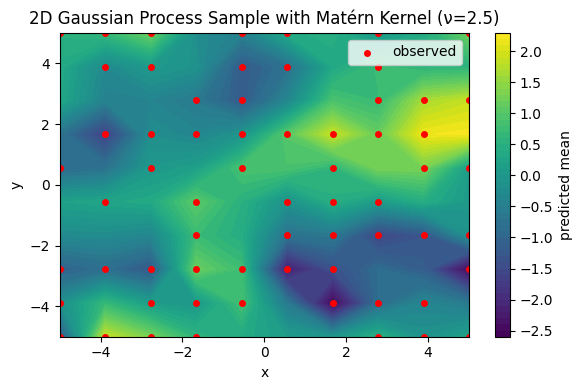

 
inference time: 17.025867700576782 sec , for 2000 samples


In [190]:
mean_64pts,std_64pts=Spatial_Inference_2d(obs_idx=obs_idx_lst[2],x_obs=x_obs_lst[2],y_obs=y_obs_lst[2],noise_scale=0.3, n_samples=2000,av=50,m_av=False)

In [24]:
#@title masked image

def plot2D(vector,title,x_obs,cbar=False,points=False,labels=False,ytitle='$f(x_1,x_2)$',stick=False):
  samples = vector.reshape(N, N)  # Generate 1 sample and reshape to 2D grid
  # Step 6: Plot the GP sample with the noisy points and the 8 random points
  #plt.figure(figsize=(6, 4))  # Increase figure size for better fitting
  plt.contourf(X_grid.numpy(), Y_grid.numpy(), samples, cmap='viridis', levels=50)
  if cbar==True:
      plt.colorbar(label= ytitle,fontsize=16)
  if points==True:
  # Mark noisy points on the grid
      plt.scatter(x_obs[:, 0], x_obs[:, 1], color='r', marker='o',s=8)

  # Ensure the plot fits the map
  plt.xlim([-5, 5])
  plt.ylim([-5, 5])
  if stick==False:
      plt.xticks([])  # Removes x-axis ticks
      plt.yticks([])  # Removes y-axis ticks
  if title:
      plt.title(title, fontsize=16)
  if labels==True:
      plt.xlabel('$x_1$')
      plt.ylabel('$x_2$')
  #plt.legend()
  plt.tight_layout()  # Adjust layout to fit everything nicely

In [25]:
# #Results_2D_exp=[mean_2D,std_2D]
# with open('Results_2D_exp.pkl', 'rb') as f:
#     mean_2D,std_2D=pickle.load(f)

In [26]:

# std_2D=[std_16pts,std_32pts,std_64pts]
# mean_2D=[mean_16pts,mean_32pts,mean_64pts]
x_obs_2D=[x_obs_lst[0],x_obs_lst[1],x_obs_lst[2]]
idx=[obs_idx_lst[0],obs_idx_lst[1],obs_idx_lst[2]]


title_mean=["$n_{obs}=16$","$n_{obs}=32$","$n_{obs}=64$"]
title_std=["standard deviation: 16 points","standard deviation: 32 points","standard deviation: 64 points"]
title_obs=["observed: 16 points" ,"observed: 32 points","observed: 64 points"]
title_rec=["reconstructed: 16 points","reconstructed: 32 points"]


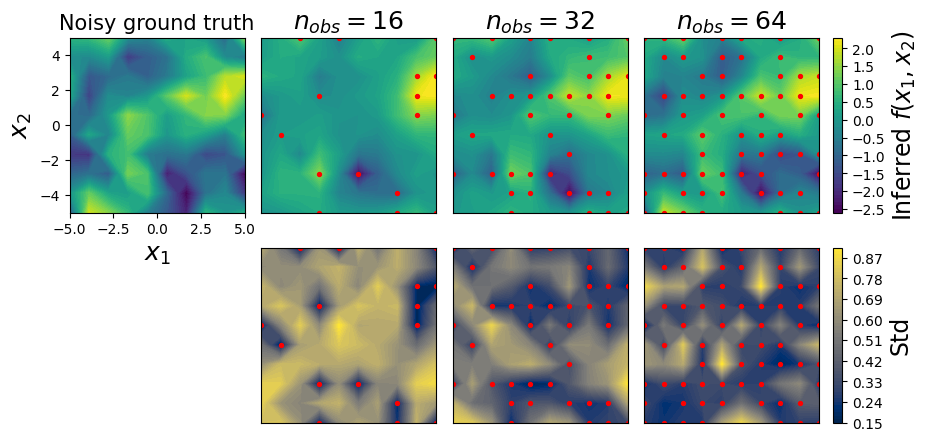

In [27]:

## plot 
def plot2D(ax, vector, title, x_obs,cmap='viridis', cbar_ax=None, points=False, labels=False, ytitle='Inferred $f(x_1,x_2)$', size=16,stick=False):
    samples = vector.reshape(N, N)
    contour = ax.contourf(X_grid.numpy(), Y_grid.numpy(), samples, cmap=cmap, levels=50)

    if cbar_ax:
        plt.colorbar(contour, cax=cbar_ax).set_label(ytitle, fontsize=17)

    if points:
        ax.scatter(x_obs[:, 0], x_obs[:, 1], color='r', marker='o', s=8)

    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 5])
    ax.set_aspect('equal')
    if stick==False:
        ax.set_xticks([])
        ax.set_yticks([])

    if title:
        ax.set_title(title, fontsize=size)
    if labels:
        ax.set_xlabel('$x_1$',fontsize=18)
        ax.set_ylabel('$x_2$',fontsize=18)

# Create figure with GridSpec layout
fig = plt.figure(figsize=(10, 5))
gs = gridspec.GridSpec(2, 5, width_ratios=[1, 1, 1, 1, 0.05], wspace=0.08)

# Plot noisy ground truth (no colorbar)
ax = fig.add_subplot(gs[0, 0])
plot2D(ax=ax, vector=samples.numpy(), title="Noisy ground truth",size=15, x_obs=x_obs_2D[0], labels=True,stick=True)

# Plot mean predictions
for i in range(3):
    ax = fig.add_subplot(gs[0, i + 1])
    cbar_ax = fig.add_subplot(gs[0, 4]) if i == 2 else None  # Add colorbar to the last plot
    plot2D(ax=ax, vector=mean_2D[i], title=title_mean[i],size=18, x_obs=x_obs_2D[i], cbar_ax=cbar_ax,points=True)

# Plot standard deviations
for i in range(3):
    ax = fig.add_subplot(gs[1, i + 1])
    cbar_ax = fig.add_subplot(gs[1, 4]) if i == 2 else None  # Add colorbar to the last plot
    plot2D(ax=ax, vector=std_2D[i], title=None, x_obs=x_obs_2D[i], points=True,cmap="cividis", cbar_ax=cbar_ax,ytitle='Std')

# Hide the unused subplot (bottom-left)
fig.add_subplot(gs[1, 0]).axis('off')

# Adjust layout
#plt.tight_layout()
plt.show()


In [28]:
# fig.savefig('last_SpatSim_2D.png', bbox_inches='tight', format='png')
#fig.savefig('last_SpatSim_2D.pdf', bbox_inches='tight', format='pdf')